In [2]:
# Quick Setup: Run essential cells to restore notebook state
print("🔄 Running essential notebook setup...")

# Check if Spark session exists
try:
    spark.version
    print("✅ Spark session is active")
except NameError:
    print("❌ Spark session not found - need to run setup cells")
    print("📋 Please run these cells in order:")
    print("   1. Environment setup cell (imports, paths)")  
    print("   2. Spark session initialization cell")
    print("   3. Table catalog cell")
    print("   4. Data scope confirmation cell")
    print("   5. Analytical dataset construction cells")

# Check if key variables exist
key_vars = ['REPO_ROOT', 'spark', 'TABLES', 'daily_df', 'analysis_df']
missing_vars = []

for var in key_vars:
    try:
        eval(var)
        print(f"✅ {var} exists")
    except NameError:
        missing_vars.append(var)
        print(f"❌ {var} missing")

if missing_vars:
    print(f"\n⚠️  Missing variables: {', '.join(missing_vars)}")
    print("Run the setup cells in order to restore these variables")
else:
    print("\n🎉 All key variables are available - notebook ready!")

🔄 Running essential notebook setup...
❌ Spark session not found - need to run setup cells
📋 Please run these cells in order:
   1. Environment setup cell (imports, paths)
   2. Spark session initialization cell
   3. Table catalog cell
   4. Data scope confirmation cell
   5. Analytical dataset construction cells
❌ REPO_ROOT missing
❌ spark missing
❌ TABLES missing
❌ daily_df missing
❌ analysis_df missing

⚠️  Missing variables: REPO_ROOT, spark, TABLES, daily_df, analysis_df
Run the setup cells in order to restore these variables


# Vietnam Air Quality Lakehouse – Research Notebook

This notebook documents the end-to-end analytical workflow for the Vietnam Air Quality (AQI) lakehouse. It is written for data scientists and analytics engineers who need traceable, reproducible results grounded in the Gold layer of the lakehouse.

## Run Book

1. Environment setup & Spark session
2. Research questions & KPI specification
3. Data scope confirmation
4. Snapshot freezing for reproducibility
5. Data quality (Great Expectations)
6. Analytical dataset materialisation
7. Exploratory data analysis (EDA)
8. Diagnostic analytics
9. Statistical inference (bootstrap + Mann–Whitney)
10. Anomaly detection
11. Nowcasting model (GBDT, 1–6 h horizons)
12. Sensitivity analysis
13. Insights & operational recommendations

In [3]:
# Environment bootstrap
import os
import sys
from pathlib import Path
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.frameon"] = False
plt.rcParams["axes.grid"] = True

REPO_ROOT = Path.cwd().resolve()
if REPO_ROOT.name == "notebooks":
    REPO_ROOT = REPO_ROOT.parent

SRC_DIR = REPO_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

FIG_DIR = REPO_ROOT / "reports" / "figures"
TABLE_DIR = REPO_ROOT / "reports" / "tables"
for directory in (FIG_DIR, TABLE_DIR):
    directory.mkdir(parents=True, exist_ok=True)

print(f"Repository root: {REPO_ROOT}")
print(f"Figures directory: {FIG_DIR}")
print(f"Tables directory: {TABLE_DIR}")

Repository root: /home/dlhnhom2/dlh-aqi
Figures directory: /home/dlhnhom2/dlh-aqi/reports/figures
Tables directory: /home/dlhnhom2/dlh-aqi/reports/tables


In [4]:
# Spark session initialisation
from aq_lakehouse.spark_session import build
from pyspark.sql import functions as F, Window
from pyspark.sql import types as T
import logging
from pyspark.sql import SparkSession
from pathlib import Path
from pyspark import SparkContext
import os

APP_NAME = "aqi_research_notebook"

# Ensure REPO_ROOT is defined if this cell is run standalone
try:
    REPO_ROOT  # type: ignore
except NameError:
    REPO_ROOT = Path.cwd().resolve()
    if REPO_ROOT.name == "notebooks":
        REPO_ROOT = REPO_ROOT.parent

# Defensive cleanup: if a stopped SparkContext object is lingering, clear it
# to avoid the `Cannot call methods on a stopped SparkContext` Py4J error.
try:
    active_sc = SparkContext._active_spark_context
    if active_sc is not None:
        try:
            active_sc.stop()
        except Exception:
            # best-effort stop
            pass
        try:
            SparkContext._active_spark_context = None
        except Exception:
            pass
except Exception:
    # ignore if Spark is not available or attribute access fails
    pass

# For notebooks, always use HDFS warehouse to access actual lakehouse data
HDFS_WAREHOUSE = os.getenv("WAREHOUSE_URI", "hdfs://khoa-master:9000/warehouse/iceberg")

# Try building the production-style Spark session (will pick up cluster settings).
# If that fails (unreachable master, misconfigured cluster), fall back to a local session
# for interactive notebook work. This keeps production code unchanged while allowing
# researcher-friendly local execution.
try:
    spark = build(APP_NAME)
    logging.info(f"Built Spark session with master={spark.sparkContext.master}")
except Exception as exc:
    logging.warning(
        "Failed to build cluster Spark session (falling back to local notebook Spark): %s",
        exc,
    )
    # Local Spark session for notebook: Use HDFS warehouse to access actual data
    # Ensure any partial/failed contexts are cleared before creating a local session
    try:
        active_sc = SparkContext._active_spark_context
        if active_sc is not None:
            try:
                active_sc.stop()
            except Exception:
                pass
            try:
                SparkContext._active_spark_context = None
            except Exception:
                pass
    except Exception:
        pass

    spark = (
        SparkSession.builder.master("local[2]")
        .appName(APP_NAME + "_local")
        .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
        .config("spark.sql.catalog.hadoop_catalog", "org.apache.iceberg.spark.SparkCatalog")
        .config("spark.sql.catalog.hadoop_catalog.type", "hadoop")
        .config("spark.sql.catalog.hadoop_catalog.warehouse", HDFS_WAREHOUSE)
        .config("spark.sql.catalogImplementation", "in-memory")
        .config("spark.sql.execution.arrow.pyspark.enabled", "false")
        .getOrCreate()
    )

spark.sparkContext.setLogLevel("WARN")
spark.conf.set("spark.sql.session.timeZone", "UTC")

print(f"Spark version: {spark.version}; master: {spark.sparkContext.master}")
print(f"Warehouse: {spark.conf.get('spark.sql.catalog.hadoop_catalog.warehouse')}")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/04 11:56:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/04 11:56:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/04 11:56:54 WARN StandaloneAppClient$ClientEndpoint: Failed to connect to master khoa-master:7077
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$

Spark version: 4.0.0; master: local[2]
Warehouse: hdfs://khoa-master:9000/warehouse/iceberg


In [5]:
# Iceberg table catalogue (Gold/Silver/Snapshot targets)
TABLES = {
    "fact_hourly": "hadoop_catalog.aq.gold.fact_air_quality_hourly",
    "dim_location": "hadoop_catalog.aq.gold.dim_location",
    "dim_date": "hadoop_catalog.aq.gold.dim_calendar_date",
    "dim_time": "hadoop_catalog.aq.gold.dim_calendar_time",
    "silver_clean": "hadoop_catalog.aq.silver.air_quality_hourly_clean",
    "silver_components": "hadoop_catalog.aq.silver.aq_components_hourly",
    "silver_index": "hadoop_catalog.aq.silver.aq_index_hourly",
}

# Check which tables are required (Gold) vs optional (Silver for advanced analysis)
required_tables = ["fact_hourly", "dim_location", "dim_date", "dim_time"]
optional_tables = ["silver_clean", "silver_components", "silver_index"]

missing_required = [TABLES[name] for name in required_tables if not spark.catalog.tableExists(TABLES[name])]
missing_optional = [TABLES[name] for name in optional_tables if not spark.catalog.tableExists(TABLES[name])]

# If running locally (not connected to the cluster), warn and continue so
# the notebook can be used for development. If running against a real cluster,
# be strict and raise an error so the user knows the required tables are missing.
is_local = str(spark.sparkContext.master).lower().startswith("local")

if missing_required:
    message = (
        "Missing required Gold tables: " + ", ".join(missing_required)
        + ".\nRun the Bronze → Silver → Gold lakehouse jobs before executing this research notebook."
    )
    if is_local:
        import warnings
        warnings.warn(message)
        print("Warning: running in local mode; continuing without required Gold tables.")
        print("Missing required tables:", missing_required)
        TABLES_AVAILABLE = False
    else:
        raise RuntimeError(message)
else:
    TABLES_AVAILABLE = True
    print("✅ All required Gold tables are present.")
    
    if missing_optional:
        import warnings
        warnings.warn(f"Optional Silver tables not found (snapshots will be skipped): {', '.join(missing_optional)}")
        print(f"⚠️  Optional Silver tables missing: {len(missing_optional)}")
    else:
        print("✅ All optional Silver tables are also present.")


✅ All required Gold tables are present.
✅ All optional Silver tables are also present.


## 1. Research Questions & KPI Blueprint

Core guiding question: *How do hourly and daily AQI patterns vary across Vietnamese cities by season, and which pollutant components dominate periods of elevated AQI?*

In [6]:
kpi_blueprint = pd.DataFrame([
    {
        "KPI": "Median AQI (daily)",
        "Purpose": "Track central tendency while limiting sensitivity to spikes.",
        "Computation": "median(aqi) per (location, date)",
    },
    {
        "KPI": "AQI category share",
        "Purpose": "Quantify proportion of hours spent in regulatory categories.",
        "Computation": "count(category == c) / total_hours",
    },
    {
        "KPI": "PM2.5 exceedance hours",
        "Purpose": "Highlight health-relevant threshold breaches (>= 35 µg/m³).",
        "Computation": "count(pm25 > threshold)",
    },
    {
        "KPI": "Data completeness",
        "Purpose": "Ensure operational coverage for each city/day.",
        "Computation": "hours_with_aqi / 24",
    },
])

kpi_blueprint

,KPI,Purpose,Computation
0,Median AQI (daily),Track central tendency while limiting sensitiv...,"median(aqi) per (location, date)"
1,AQI category share,Quantify proportion of hours spent in regulato...,count(category == c) / total_hours
2,PM2.5 exceedance hours,Highlight health-relevant threshold breaches (...,count(pm25 > threshold)
3,Data completeness,Ensure operational coverage for each city/day.,hours_with_aqi / 24


## 2. Data Scope Confirmation

In [7]:
# Data Scope Confirmation
# Load tables when available; otherwise create empty placeholder DataFrames so the
# rest of the notebook can run in local/dev mode without Iceberg.
from pyspark.sql import types as T

if 'TABLES_AVAILABLE' in globals() and TABLES_AVAILABLE:
    fact_df = spark.table(TABLES["fact_hourly"]).cache()
    dim_location_df = spark.table(TABLES["dim_location"]).cache()
    dim_date_df = spark.table(TABLES["dim_date"]).cache()
    dim_time_df = spark.table(TABLES["dim_time"]).cache()
else:
    # Define schemas matching Gold layer structure exactly
    fact_schema = T.StructType([
        T.StructField('location_key', T.StringType(), True),
        T.StructField('date_key', T.StringType(), True),
        T.StructField('time_key', T.StringType(), True),
        T.StructField('ts_utc', T.TimestampType(), True),
        T.StructField('date_utc', T.DateType(), True),
        T.StructField('pm25', T.DoubleType(), True),
        T.StructField('pm10', T.DoubleType(), True),
        T.StructField('o3', T.DoubleType(), True),
        T.StructField('no2', T.DoubleType(), True),
        T.StructField('so2', T.DoubleType(), True),
        T.StructField('co', T.DoubleType(), True),
        T.StructField('aod', T.DoubleType(), True),
        T.StructField('uv_index', T.DoubleType(), True),
        T.StructField('uv_index_clear_sky', T.DoubleType(), True),
        T.StructField('pm25_24h_avg', T.DoubleType(), True),
        T.StructField('pm10_24h_avg', T.DoubleType(), True),
        T.StructField('pm25_nowcast', T.DoubleType(), True),
        T.StructField('o3_8h_max', T.DoubleType(), True),
        T.StructField('no2_1h_max', T.DoubleType(), True),
        T.StructField('so2_1h_max', T.DoubleType(), True),
        T.StructField('co_8h_avg', T.DoubleType(), True),
        T.StructField('aqi', T.IntegerType(), True),
        T.StructField('category', T.StringType(), True),
        T.StructField('dominant_pollutant', T.StringType(), True),
        T.StructField('is_validated', T.BooleanType(), True),
        T.StructField('quality_flag', T.StringType(), True),
        T.StructField('data_source', T.StringType(), True),
        T.StructField('run_id', T.StringType(), True),
        T.StructField('ingested_at', T.TimestampType(), True),
        T.StructField('computed_at', T.TimestampType(), True),
        T.StructField('component_calc_method', T.StringType(), True),
        T.StructField('index_calc_method', T.StringType(), True),
        T.StructField('created_at', T.TimestampType(), True),
        T.StructField('updated_at', T.TimestampType(), True),
    ])

    dim_location_schema = T.StructType([
        T.StructField('location_key', T.StringType(), True),
        T.StructField('location_name', T.StringType(), True),
        T.StructField('latitude', T.DoubleType(), True),
        T.StructField('longitude', T.DoubleType(), True),
        T.StructField('country', T.StringType(), True),
        T.StructField('admin1', T.StringType(), True),
        T.StructField('timezone', T.StringType(), True),
        T.StructField('is_active', T.BooleanType(), True),
        T.StructField('valid_from', T.DateType(), True),
        T.StructField('valid_to', T.DateType(), True),
        T.StructField('created_at', T.TimestampType(), True),
        T.StructField('updated_at', T.TimestampType(), True),
    ])

    dim_date_schema = T.StructType([
        T.StructField('date_key', T.StringType(), True),
        T.StructField('date_utc', T.DateType(), True),
        T.StructField('year', T.IntegerType(), True),
        T.StructField('month', T.IntegerType(), True),
        T.StructField('day', T.IntegerType(), True),
        T.StructField('dow', T.IntegerType(), True),
        T.StructField('week', T.IntegerType(), True),
        T.StructField('is_weekend', T.BooleanType(), True),
        T.StructField('quarter', T.IntegerType(), True),
        T.StructField('month_name', T.StringType(), True),
        T.StructField('day_name', T.StringType(), True),
        T.StructField('created_at', T.TimestampType(), True),
        T.StructField('updated_at', T.TimestampType(), True),
    ])

    dim_time_schema = T.StructType([
        T.StructField('time_key', T.StringType(), True),
        T.StructField('hour', T.IntegerType(), True),
        T.StructField('hour_label', T.StringType(), True),
        T.StructField('is_am', T.BooleanType(), True),
        T.StructField('day_part', T.StringType(), True),
        T.StructField('created_at', T.TimestampType(), True),
        T.StructField('updated_at', T.TimestampType(), True),
    ])

    fact_df = spark.createDataFrame([], schema=fact_schema)
    dim_location_df = spark.createDataFrame([], schema=dim_location_schema)
    dim_date_df = spark.createDataFrame([], schema=dim_date_schema)
    dim_time_df = spark.createDataFrame([], schema=dim_time_schema)

    import warnings
    warnings.warn('TABLES are not available; using empty placeholder DataFrames. Many downstream results will be empty.')

# Build a small scope summary; safe when DataFrames are empty
scope_summary = (
    fact_df
    .agg(
        F.min("ts_utc").alias("min_ts_utc"),
        F.max("ts_utc").alias("max_ts_utc"),
        F.countDistinct("location_key").alias("locations"),
        F.count("*").alias("rows"),
    )
    .toPandas()
)

locations_detail = dim_location_df.select("location_key", "location_name", "admin1", "country", "timezone").orderBy("location_key")

print("Scope overview:")
display(scope_summary)

print("Active monitoring locations:")
display(locations_detail.toPandas())

25/10/04 11:58:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Scope overview:


,min_ts_utc,max_ts_utc,locations,rows
0,2024-01-01,2025-08-31 23:00:00,3,43848


Active monitoring locations:


,location_key,location_name,admin1,country,timezone
0,Hà Nội,Hà Nội,None,None,None
1,TP. Hồ Chí Minh,TP. Hồ Chí Minh,None,None,None
2,Đà Nẵng,Đà Nẵng,None,None,None


## 3. Snapshot Freezing (Reproducibility)

In [8]:
SNAPSHOT_TARGETS = [
    ("gold", TABLES["fact_hourly"]),
    ("gold", TABLES["dim_location"]),
    ("gold", TABLES["dim_date"]),
    ("gold", TABLES["dim_time"]),
    ("silver", TABLES["silver_clean"]),
    ("silver", TABLES["silver_components"]),
    ("silver", TABLES["silver_index"]),
]

run_ts = datetime.now(timezone.utc)
snapshot_records = []

def create_manual_snapshot(table_name: str, layer: str) -> dict:
    """Create a manual snapshot by recording table metadata and sample statistics"""
    snapshot_record = {
        "layer": layer,
        "table": table_name,
        "recorded_at_utc": run_ts.isoformat(),
        "snapshot_method": "manual_metadata",
    }
    
    try:
        # Get table metadata
        df = spark.table(table_name)
        
        # Basic statistics
        row_count = df.count()
        snapshot_record["row_count"] = row_count
        
        # Schema fingerprint
        schema_summary = [(f.name, f.dataType.simpleString()) for f in df.schema]
        snapshot_record["schema_columns"] = len(schema_summary)
        snapshot_record["schema_fingerprint"] = hash(str(schema_summary))
        
        # Time range (if table has timestamp columns)
        timestamp_cols = [f.name for f in df.schema if f.dataType.simpleString() in ['timestamp', 'date']]
        if timestamp_cols:
            # Use first timestamp column for range
            ts_col = timestamp_cols[0]
            time_stats = df.agg(
                F.min(ts_col).alias("min_ts"),
                F.max(ts_col).alias("max_ts")
            ).collect()[0]
            snapshot_record["data_min_ts"] = str(time_stats["min_ts"]) if time_stats["min_ts"] else None
            snapshot_record["data_max_ts"] = str(time_stats["max_ts"]) if time_stats["max_ts"] else None
        
        # Try to get Iceberg table properties/history (if available)
        try:
            # Try SHOW TBLPROPERTIES for Iceberg metadata
            props_df = spark.sql(f"SHOW TBLPROPERTIES {table_name}")
            props = {row['key']: row['value'] for row in props_df.collect()}
            
            # Extract useful Iceberg properties
            if 'current-snapshot-id' in props:
                snapshot_record["iceberg_snapshot_id"] = props['current-snapshot-id']
            if 'uuid' in props:
                snapshot_record["table_uuid"] = props['uuid']
                
        except Exception:
            # SHOW TBLPROPERTIES not available or failed
            pass
            
        # Try table history (if Iceberg supports it)
        try:
            history_df = spark.sql(f"SELECT * FROM {table_name}.history ORDER BY made_current_at DESC LIMIT 1")
            if history_df.count() > 0:
                latest_history = history_df.collect()[0]
                snapshot_record["iceberg_snapshot_id"] = str(latest_history.get("snapshot_id", "unknown"))
                snapshot_record["iceberg_committed_at"] = str(latest_history.get("made_current_at", "unknown"))
        except Exception:
            # Table history not available
            pass
            
        snapshot_record["status"] = "success"
        print(f"✅ Manual snapshot created for {table_name} ({row_count:,} rows)")
        
    except Exception as e:
        snapshot_record["status"] = "failed"
        snapshot_record["error"] = str(e)
        print(f"❌ Failed to create manual snapshot for {table_name}: {e}")
    
    return snapshot_record

# Skip snapshot creation in local/dev mode when TABLES are not available
if 'TABLES_AVAILABLE' in globals() and TABLES_AVAILABLE:
    for layer, table_name in SNAPSHOT_TARGETS:
        # Check if table exists before creating snapshot
        if not spark.catalog.tableExists(table_name):
            print(f"⚠️  Skipping snapshot for missing table: {table_name}")
            continue
            
        # Use manual snapshot approach instead of stored procedure
        snapshot_record = create_manual_snapshot(table_name, layer)
        snapshot_records.append(snapshot_record)

    if snapshot_records:
        snapshot_df = pd.DataFrame(snapshot_records)
        display(snapshot_df)

        # Persist snapshot metadata into docs/system_report.md (append section)
        system_report_path = REPO_ROOT / "docs" / "system_report.md"
        section_header = "## Lakehouse Snapshots (analysis freeze)"
        if system_report_path.exists():
            existing = system_report_path.read_text(encoding="utf-8")
            if section_header in existing:
                before, _, _ = existing.partition(section_header)
                system_report_path.write_text(before.rstrip() + "\n", encoding="utf-8")

        with system_report_path.open("a", encoding="utf-8") as handle:
            handle.write(f"{section_header}\n")
            handle.write(f"- Captured: {run_ts.isoformat()}\n")
            handle.write(f"- Method: Manual metadata snapshot (fallback)\n")
            for record in snapshot_records:
                if record.get("status") == "success":
                    snapshot_id = record.get("iceberg_snapshot_id", record.get("schema_fingerprint", "manual"))
                    row_count = record.get("row_count", "unknown")
                    handle.write(f"  - {record['table']} → snapshot_id={snapshot_id} ({row_count} rows)\n")
                else:
                    handle.write(f"  - {record['table']} → FAILED: {record.get('error', 'unknown')}\n")

        print(f"Snapshot metadata appended to {system_report_path}")
        
        # Success summary
        successful_snapshots = len([r for r in snapshot_records if r.get("status") == "success"])
        total_snapshots = len(snapshot_records)
        print(f"📊 Snapshot summary: {successful_snapshots}/{total_snapshots} tables captured successfully")
        
    else:
        print("⚠️  No snapshots created (no tables available).")
else:
    import warnings
    warnings.warn("TABLES unavailable; skipping snapshot creation.")
    print("Skipping snapshot freezing because TABLES_AVAILABLE=False")

✅ Manual snapshot created for hadoop_catalog.aq.gold.fact_air_quality_hourly (43,848 rows)
✅ Manual snapshot created for hadoop_catalog.aq.gold.dim_location (3 rows)
✅ Manual snapshot created for hadoop_catalog.aq.gold.dim_location (3 rows)
✅ Manual snapshot created for hadoop_catalog.aq.gold.dim_calendar_date (609 rows)
✅ Manual snapshot created for hadoop_catalog.aq.gold.dim_calendar_date (609 rows)
✅ Manual snapshot created for hadoop_catalog.aq.gold.dim_calendar_time (24 rows)
✅ Manual snapshot created for hadoop_catalog.aq.gold.dim_calendar_time (24 rows)
✅ Manual snapshot created for hadoop_catalog.aq.silver.air_quality_hourly_clean (43,848 rows)
✅ Manual snapshot created for hadoop_catalog.aq.silver.air_quality_hourly_clean (43,848 rows)
✅ Manual snapshot created for hadoop_catalog.aq.silver.aq_components_hourly (43,848 rows)
✅ Manual snapshot created for hadoop_catalog.aq.silver.aq_components_hourly (43,848 rows)
✅ Manual snapshot created for hadoop_catalog.aq.silver.aq_index_h

,layer,table,recorded_at_utc,snapshot_method,row_count,schema_columns,schema_fingerprint,data_min_ts,data_max_ts,iceberg_snapshot_id,status
0,gold,hadoop_catalog.aq.gold.fact_air_quality_hourly,2025-10-04T11:58:48.286475+00:00,manual_metadata,43848,34,-8081759488651768474,2024-01-01 00:00:00,2025-08-31 23:00:00,5113860104107170895,success
1,gold,hadoop_catalog.aq.gold.dim_location,2025-10-04T11:58:48.286475+00:00,manual_metadata,3,12,-5124583999799986283,None,None,2313316942555255018,success
2,gold,hadoop_catalog.aq.gold.dim_calendar_date,2025-10-04T11:58:48.286475+00:00,manual_metadata,609,13,3929569942285067862,2024-01-01,2025-08-31,707119989561850929,success
3,gold,hadoop_catalog.aq.gold.dim_calendar_time,2025-10-04T11:58:48.286475+00:00,manual_metadata,24,7,-763843122593695523,2025-10-02 13:13:13.454929,2025-10-02 13:13:13.454929,3619548003222607476,success
4,silver,hadoop_catalog.aq.silver.air_quality_hourly_clean,2025-10-04T11:58:48.286475+00:00,manual_metadata,43848,22,8572453435908004847,2024-01-01 00:00:00,2025-08-31 23:00:00,6864957037459163719,success
5,silver,hadoop_catalog.aq.silver.aq_components_hourly,2025-10-04T11:58:48.286475+00:00,manual_metadata,43848,13,-8329909356544079353,2024-01-01 00:00:00,2025-08-31 23:00:00,1285286009587970179,success
6,silver,hadoop_catalog.aq.silver.aq_index_hourly,2025-10-04T11:58:48.286475+00:00,manual_metadata,43848,15,-1523113197470006015,2024-01-01 00:00:00,2025-08-31 23:00:00,6017977126908461373,success


Snapshot metadata appended to /home/dlhnhom2/dlh-aqi/docs/system_report.md
📊 Snapshot summary: 7/7 tables captured successfully


In [10]:
# Snapshot diagnostics (debug cell)
# Prints diagnostic info to explain Why CALL hadoop_catalog.system.create_snapshot_id failed
from pprint import pprint
import traceback

print('--- Snapshot diagnostics ---')
print('TABLES_AVAILABLE:', globals().get('TABLES_AVAILABLE', None))
print('Spark master:', spark.sparkContext.master)
try:
    print('Catalog list (current):', spark.catalog.listTables())
except Exception as e:
    print('Cannot listTables():', e)

for layer, table_name in SNAPSHOT_TARGETS:
    try:
        exists = spark.catalog.tableExists(table_name)
    except Exception as e:
        exists = False
        print(f'Error checking tableExists for {table_name}: {e}')
    print(f'Table: {table_name} | exists: {exists}')
    if exists:
        try:
            df = spark.table(table_name)
            print('  Rows (count):', df.count())
            print('  Schema sample:', [(f.name, f.dataType.simpleString()) for f in df.schema][:20])
            print('  Sample row:')
            display(df.limit(1).toPandas())
        except Exception as e:
            print('  Error reading sample:', e)

# Try SHOW PROCEDURES / SHOW FUNCTIONS matching the system.create_snapshot route
procs = []
try:
    try:
        procs = spark.sql('SHOW PROCEDURES').toPandas()
    except Exception:
        procs = None
    if procs is not None and not procs.empty:
        print('\nAvailable procedures (first 20):')
        display(procs.head(20))
    else:
        print('\nSHOW PROCEDURES not available or returned empty')
        # Try SHOW FUNCTIONS as fallback
        try:
            funcs = spark.sql("SHOW FUNCTIONS LIKE 'system.create_%'").toPandas()
            if not funcs.empty:
                print('Functions matching system.create_*:')
                display(funcs)
            else:
                print('No functions matching system.create_* found')
        except Exception as e:
            print('SHOW FUNCTIONS failed:', e)
except Exception as e:
    print('Error while listing procedures/functions:', e)
    traceback.print_exc()

print('\nAttempting DESCRIBE PROCEDURE hadoop_catalog.system.create_snapshot_id (if supported)')
try:
    print( spark.sql("DESCRIBE PROCEDURE hadoop_catalog.system.create_snapshot_id").toPandas() )
except Exception as e:
    print('DESCRIBE PROCEDURE failed:', e)
    traceback.print_exc()

print('\nDiagnostics complete. Next steps:')
print('- If routine is missing: Iceberg catalog does not expose the system.create_snapshot_id procedure in this Spark build or catalog configuration.')
print('- If permission error: run with a user that has privileges or configure catalog to allow CALLs.')
print('- Fallback approach: record table metadata (e.g., show table history) or copy current partitions/metadata into analysis namespace as a manual snapshot.')

--- Snapshot diagnostics ---
TABLES_AVAILABLE: True
Spark master: local[2]
Catalog list (current): []
Table: hadoop_catalog.aq.gold.fact_air_quality_hourly | exists: True


  Rows (count): 43848
  Schema sample: [('location_key', 'string'), ('date_key', 'string'), ('time_key', 'string'), ('ts_utc', 'timestamp'), ('date_utc', 'date'), ('pm25', 'double'), ('pm10', 'double'), ('o3', 'double'), ('no2', 'double'), ('so2', 'double'), ('co', 'double'), ('aod', 'double'), ('uv_index', 'double'), ('uv_index_clear_sky', 'double'), ('pm25_24h_avg', 'double'), ('pm10_24h_avg', 'double'), ('pm25_nowcast', 'double'), ('o3_8h_max', 'double'), ('no2_1h_max', 'double'), ('so2_1h_max', 'double')]
  Sample row:


,location_key,date_key,time_key,ts_utc,date_utc,pm25,pm10,o3,no2,so2,...,is_validated,quality_flag,data_source,run_id,ingested_at,computed_at,component_calc_method,index_calc_method,created_at,updated_at
0,TP. Hồ Chí Minh,20250529,00,2025-05-29,2025-05-29,29.299999,29.9,19.0,40.400002,25.5,...,True,validated,open-meteo,adf629eb-ac7f-4ad8-9438-62a0ab780726,2025-10-02 13:07:45.887630,2025-10-02 13:18:29.718543,simple_rolling_v1,epa_like_v1,2025-10-02 13:18:29.718543,2025-10-02 13:18:29.718543


Table: hadoop_catalog.aq.gold.dim_location | exists: True
  Rows (count): 3
  Schema sample: [('location_key', 'string'), ('location_name', 'string'), ('latitude', 'double'), ('longitude', 'double'), ('country', 'string'), ('admin1', 'string'), ('timezone', 'string'), ('is_active', 'boolean'), ('valid_from', 'date'), ('valid_to', 'date'), ('created_at', 'timestamp'), ('updated_at', 'timestamp')]
  Sample row:


,location_key,location_name,latitude,longitude,country,admin1,timezone,is_active,valid_from,valid_to,created_at,updated_at
0,Hà Nội,Hà Nội,21.028511,105.804817,None,None,None,True,None,None,2025-10-02 12:41:32.147543,2025-10-02 12:41:32.147543


Table: hadoop_catalog.aq.gold.dim_calendar_date | exists: True
  Rows (count): 609
  Schema sample: [('date_key', 'string'), ('date_utc', 'date'), ('year', 'int'), ('month', 'int'), ('day', 'int'), ('dow', 'int'), ('week', 'int'), ('is_weekend', 'boolean'), ('quarter', 'int'), ('month_name', 'string'), ('day_name', 'string'), ('created_at', 'timestamp'), ('updated_at', 'timestamp')]
  Sample row:
  Rows (count): 609
  Schema sample: [('date_key', 'string'), ('date_utc', 'date'), ('year', 'int'), ('month', 'int'), ('day', 'int'), ('dow', 'int'), ('week', 'int'), ('is_weekend', 'boolean'), ('quarter', 'int'), ('month_name', 'string'), ('day_name', 'string'), ('created_at', 'timestamp'), ('updated_at', 'timestamp')]
  Sample row:


,date_key,date_utc,year,month,day,dow,week,is_weekend,quarter,month_name,day_name,created_at,updated_at
0,20240101,2024-01-01,2024,1,1,1,1,False,1,January,Monday,2025-10-02 13:12:49.409997,2025-10-02 13:12:49.409997


Table: hadoop_catalog.aq.gold.dim_calendar_time | exists: True
  Rows (count): 24
  Schema sample: [('time_key', 'string'), ('hour', 'int'), ('hour_label', 'string'), ('is_am', 'boolean'), ('day_part', 'string'), ('created_at', 'timestamp'), ('updated_at', 'timestamp')]
  Sample row:


,time_key,hour,hour_label,is_am,day_part,created_at,updated_at
0,08,8,08:00,True,Morning,2025-10-02 13:13:13.454929,2025-10-02 13:13:13.454929


Table: hadoop_catalog.aq.silver.air_quality_hourly_clean | exists: True
  Rows (count): 43848
  Schema sample: [('location_id', 'string'), ('latitude', 'double'), ('longitude', 'double'), ('ts_utc', 'timestamp'), ('date_utc', 'date'), ('aod', 'double'), ('pm25', 'double'), ('pm10', 'double'), ('dust', 'double'), ('no2', 'double'), ('o3', 'double'), ('so2', 'double'), ('co', 'double'), ('uv_index', 'double'), ('uv_index_clear_sky', 'double'), ('source', 'string'), ('bronze_run_id', 'string'), ('bronze_ingested_at', 'timestamp'), ('run_id', 'string'), ('ingested_at', 'timestamp')]
  Sample row:


,location_id,latitude,longitude,ts_utc,date_utc,aod,pm25,pm10,dust,no2,...,co,uv_index,uv_index_clear_sky,source,bronze_run_id,bronze_ingested_at,run_id,ingested_at,valid_flags,notes
0,Hà Nội,21.028511,105.804817,2024-10-31,2024-10-31,0.35,72.599998,103.800003,0.0,34.299999,...,2698.0,0.45,0.45,open-meteo,ba6f1f3a-32cc-4910-ae36-bc96412ea253,2025-10-02 12:33:44.398178,4048e8e6-d2f4-468b-80fd-36c2ee2b8549,2025-10-02 13:04:50.148742,"{'o3_nonneg': True, 'aod_nonneg': True, 'pm25_...",None


Table: hadoop_catalog.aq.silver.aq_components_hourly | exists: True
  Rows (count): 43848
  Schema sample: [('location_id', 'string'), ('ts_utc', 'timestamp'), ('date_utc', 'date'), ('pm25_24h_avg', 'double'), ('pm10_24h_avg', 'double'), ('o3_8h_max', 'double'), ('co_8h_max', 'double'), ('no2_1h_max', 'double'), ('so2_1h_max', 'double'), ('component_valid_flags', 'map<string,boolean>'), ('calc_method', 'string'), ('run_id', 'string'), ('computed_at', 'timestamp')]
  Sample row:


,location_id,ts_utc,date_utc,pm25_24h_avg,pm10_24h_avg,o3_8h_max,co_8h_max,no2_1h_max,so2_1h_max,component_valid_flags,calc_method,run_id,computed_at
0,Hà Nội,2025-07-14,2025-07-14,74.737499,74.791666,73.0,1109.0,27.200001,16.4,"{'pm25_24h_sufficient': True, 'continuous_hour...",simple_rolling_v1,8e03aa78-e988-4a09-9781-6ac31978e23a,2025-10-02 13:09:42.716129


Table: hadoop_catalog.aq.silver.aq_index_hourly | exists: True
  Rows (count): 43848
  Schema sample: [('location_id', 'string'), ('ts_utc', 'timestamp'), ('date_utc', 'date'), ('aqi', 'int'), ('category', 'string'), ('dominant_pollutant', 'string'), ('aqi_pm25', 'int'), ('aqi_pm10', 'int'), ('aqi_o3', 'int'), ('aqi_no2', 'int'), ('aqi_so2', 'int'), ('aqi_co', 'int'), ('calc_method', 'string'), ('run_id', 'string'), ('computed_at', 'timestamp')]
  Sample row:


,location_id,ts_utc,date_utc,aqi,category,dominant_pollutant,aqi_pm25,aqi_pm10,aqi_o3,aqi_no2,aqi_so2,aqi_co,calc_method,run_id,computed_at
0,Hà Nội,2024-09-29,2024-09-29,3087,Hazardous,co,72,31,23,9,12,3087,epa_like_v1,cbd24db7-972b-4f43-83c8-54d14d326151,2025-10-02 13:04:22.019432


{"ts": "2025-10-04 11:59:10.852", "level": "ERROR", "logger": "SQLQueryContextLogger", "msg": "[TABLE_OR_VIEW_NOT_FOUND] The table or view `PROCEDURE` cannot be found. Verify the spelling and correctness of the schema and catalog.\nIf you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.\nTo tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS. SQLSTATE: 42P01", "context": {"errorClass": "TABLE_OR_VIEW_NOT_FOUND"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o92.sql.\n: org.apache.spark.sql.AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `PROCEDURE` cannot be found. Verify the spelling and correctness of the schema and catalog.\nIf you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.\nTo tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABL


SHOW PROCEDURES not available or returned empty
No functions matching system.create_* found

Attempting DESCRIBE PROCEDURE hadoop_catalog.system.create_snapshot_id (if supported)
DESCRIBE PROCEDURE failed: [TABLE_OR_VIEW_NOT_FOUND] The table or view `PROCEDURE` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS. SQLSTATE: 42P01; line 1 pos 9;
'DescribeColumn 'hadoop_catalog.system.create_snapshot_id, false, [info_name#12943, info_value#12944]
+- 'UnresolvedTableOrView [PROCEDURE], DESCRIBE TABLE, true


Diagnostics complete. Next steps:
- If routine is missing: Iceberg catalog does not expose the system.create_snapshot_id procedure in this Spark build or catalog configuration.
- If permission error: run with a user that has privileges or conf

Traceback (most recent call last):
  File "/tmp/ipykernel_5963/1362508824.py", line 59, in <module>
    print( spark.sql("DESCRIBE PROCEDURE hadoop_catalog.system.create_snapshot_id").toPandas() )
  File "/home/dlhnhom2/.local/lib/python3.10/site-packages/pyspark/sql/session.py", line 1810, in sql
    return DataFrame(self._jsparkSession.sql(sqlQuery, litArgs), self)
  File "/home/dlhnhom2/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1362, in __call__
    return_value = get_return_value(
  File "/home/dlhnhom2/.local/lib/python3.10/site-packages/pyspark/errors/exceptions/captured.py", line 288, in deco
    raise converted from None
pyspark.errors.exceptions.captured.AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `PROCEDURE` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate

## 4. Data Quality Gate (Great Expectations)

In [11]:
# Ensure Great Expectations (Spark) is available
try:
    import great_expectations as ge
    from great_expectations.dataset import SparkDFDataset
except ModuleNotFoundError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "great_expectations[spark]==0.15.50"])
    import great_expectations as ge
    from great_expectations.dataset import SparkDFDataset

from typing import List, Dict

def summarise_expectation(result: Dict, table_label: str, check_name: str, layer: str) -> Dict:
    expectation_config = result.get("expectation_config", {})
    return {
        "layer": layer,
        "table": table_label,
        "check": check_name,
        "success": bool(result.get("success")),
        "unexpected_percent": result.get("result", {}).get("unexpected_percent"),
        "details": expectation_config.get("kwargs", {}),
    }

summary_rows: List[Dict] = []

# If we don't have tables available (local dev), skip heavy expectations and provide placeholders
if 'TABLES_AVAILABLE' in globals() and not TABLES_AVAILABLE:
    import warnings

    warnings.warn("TABLES unavailable; skipping Great Expectations checks in local mode.")
    # Provide a minimal DQ summary indicating skipped checks
    summary_rows.append({
        "layer": "gold",
        "table": TABLES["fact_hourly"],
        "check": "skipped",
        "success": None,
        "unexpected_percent": None,
        "details": {"reason": "TABLES_AVAILABLE=False"},
    })
else:
    # Gold fact table expectations
    fact_expect = SparkDFDataset(
        fact_df.select(
            "location_key", "ts_utc", "aqi", "pm25", "pm10", "o3", "no2", "so2", "co"
        )
    )

    # Use expectation methods available in this GE version; map to conservative equivalents
    try:
        res = fact_expect.expect_column_values_to_not_be_null("aqi")
        summary_rows.append(summarise_expectation(res, TABLES["fact_hourly"], "AQI not null", "gold"))
    except AttributeError:
        # Fallback: run a simple null check using Spark and craft a fake GE-like result
        null_count = fact_df.filter(F.col("aqi").isNull()).count()
        total = fact_df.count()
        summary_rows.append({
            "layer": "gold",
            "table": TABLES["fact_hourly"],
            "check": "AQI not null",
            "success": (null_count == 0),
            "unexpected_percent": (null_count / total if total > 0 else None),
            "details": {},
        })

    # Bounded AQI
    try:
        res = fact_expect.expect_column_values_to_be_between("aqi", min_value=0, max_value=500)
        summary_rows.append(summarise_expectation(res, TABLES["fact_hourly"], "AQI within 0-500", "gold"))
    except AttributeError:
        # Fallback
        out_of_bounds = fact_df.filter((F.col("aqi") < 0) | (F.col("aqi") > 500)).count()
        total = fact_df.count()
        summary_rows.append({
            "layer": "gold",
            "table": TABLES["fact_hourly"],
            "check": "AQI within 0-500",
            "success": (out_of_bounds == 0),
            "unexpected_percent": (out_of_bounds / total if total > 0 else None),
            "details": {},
        })

    # PM2.5 non-negative
    try:
        res = fact_expect.expect_column_values_to_be_greater_than("pm25", min_value=-1e-9)
        summary_rows.append(summarise_expectation(res, TABLES["fact_hourly"], "PM2.5 non-negative", "gold"))
    except AttributeError:
        try:
            out_of_bounds = fact_df.filter(F.col("pm25") < 0).count()
            total = fact_df.count()
            summary_rows.append({
                "layer": "gold",
                "table": TABLES["fact_hourly"],
                "check": "PM2.5 non-negative",
                "success": (out_of_bounds == 0),
                "unexpected_percent": (out_of_bounds / total if total > 0 else None),
                "details": {},
            })
        except Exception:
            summary_rows.append({
                "layer": "gold",
                "table": TABLES["fact_hourly"],
                "check": "PM2.5 non-negative",
                "success": None,
                "unexpected_percent": None,
                "details": {"reason": "fallback failed"},
            })

    # Uniqueness on (location_key, ts_utc)
    try:
        res = fact_expect.expect_compound_columns_to_be_unique(["location_key", "ts_utc"])
        summary_rows.append(summarise_expectation(res, TABLES["fact_hourly"], "Unique (location_key, ts_utc)", "gold"))
    except AttributeError:
        dup_count = fact_df.groupBy("location_key", "ts_utc").count().filter(F.col("count") > 1).count()
        summary_rows.append({
            "layer": "gold",
            "table": TABLES["fact_hourly"],
            "check": "Unique (location_key, ts_utc)",
            "success": (dup_count == 0),
            "unexpected_percent": None,
            "details": {},
        })

    # Completeness ≥95% per (location, day)
    daily_completeness = (
        fact_df
        .withColumn("date_utc", F.to_date("ts_utc"))
        .groupBy("location_key", "date_utc")
        .agg(
            (F.avg(F.when(F.col("aqi").isNotNull(), 1.0).otherwise(0.0))).alias("aqi_completeness")
        )
    )
    completeness_expect = SparkDFDataset(daily_completeness)
    try:
        res = completeness_expect.expect_column_values_to_be_greater_than("aqi_completeness", value=0.95 - 1e-6)
        summary_rows.append(summarise_expectation(res, TABLES["fact_hourly"], "AQI completeness ≥95%", "gold"))
    except AttributeError:
        # Fallback using Spark
        low_coverage = daily_completeness.filter(F.col("aqi_completeness") < (0.95 - 1e-6)).count()
        total_days = daily_completeness.count()
        summary_rows.append({
            "layer": "gold",
            "table": TABLES["fact_hourly"],
            "check": "AQI completeness ≥95%",
            "success": (low_coverage == 0),
            "unexpected_percent": (low_coverage / total_days if total_days > 0 else None),
            "details": {},
        })

    # Silver uniqueness checks
    for table_label in ("silver_clean", "silver_components", "silver_index"):
        silver_df = spark.table(TABLES[table_label])
        try:
            expectation = SparkDFDataset(silver_df.select("location_id", "ts_utc"))
            res = expectation.expect_compound_columns_to_be_unique(["location_id", "ts_utc"])
            summary_rows.append(summarise_expectation(res, TABLES[table_label], "Unique (location_id, ts_utc)", "silver",))
        except AttributeError:
            dup = silver_df.groupBy("location_id", "ts_utc").count().filter(F.col("count") > 1).count()
            summary_rows.append({
                "layer": "silver",
                "table": TABLES[table_label],
                "check": "Unique (location_id, ts_utc)",
                "success": (dup == 0),
                "unexpected_percent": None,
                "details": {},
            })

# Compile DQ summary
dq_summary = pd.DataFrame(summary_rows)
display(dq_summary)

# Persist to CSV for appendix
dq_table_path = TABLE_DIR / "aqi_dq_summary.csv"
dq_summary.to_csv(dq_table_path, index=False)
print(f"DQ summary exported to {dq_table_path}")


,layer,table,check,success,unexpected_percent,details
0,gold,hadoop_catalog.aq.gold.fact_air_quality_hourly,AQI not null,True,0.000000,"{'column': 'aqi', 'result_format': 'BASIC'}"
1,gold,hadoop_catalog.aq.gold.fact_air_quality_hourly,AQI within 0-500,False,99.965791,"{'column': 'aqi', 'min_value': 0, 'max_value':..."
2,gold,hadoop_catalog.aq.gold.fact_air_quality_hourly,PM2.5 non-negative,True,0.000000,{}
3,gold,hadoop_catalog.aq.gold.fact_air_quality_hourly,"Unique (location_key, ts_utc)",True,0.000000,"{'column_list': ['location_key', 'ts_utc'], 'r..."
4,gold,hadoop_catalog.aq.gold.fact_air_quality_hourly,AQI completeness ≥95%,True,0.000000,{}
5,silver,hadoop_catalog.aq.silver.air_quality_hourly_clean,"Unique (location_id, ts_utc)",True,0.000000,"{'column_list': ['location_id', 'ts_utc'], 're..."
6,silver,hadoop_catalog.aq.silver.aq_components_hourly,"Unique (location_id, ts_utc)",True,0.000000,"{'column_list': ['location_id', 'ts_utc'], 're..."
7,silver,hadoop_catalog.aq.silver.aq_index_hourly,"Unique (location_id, ts_utc)",True,0.000000,"{'column_list': ['location_id', 'ts_utc'], 're..."


DQ summary exported to /home/dlhnhom2/dlh-aqi/reports/tables/aqi_dq_summary.csv


## 5. Analytical Dataset Construction

In [12]:
# Join Fact + Dimensions → hourly analytical view (robust to duplicate column names)
analysis_df = (
    fact_df.alias("f")
    .join(dim_location_df.alias("loc"), on="location_key", how="left")
    .join(dim_date_df.alias("dd"), on="date_key", how="left")
    .join(dim_time_df.alias("dt"), on="time_key", how="left")
    .select(
        F.col("f.location_key").alias("location_key"),
        F.col("loc.location_name").alias("location_name"),
        F.col("loc.admin1").alias("admin1"),
        F.col("loc.country").alias("country"),
        F.coalesce(F.col("f.date_utc"), F.col("dd.date_utc")).alias("date_utc"),
        F.col("dd.year").alias("year"),
        F.col("dd.month").alias("month"),
        F.col("dd.day").alias("day"),
        F.col("dd.dow").alias("dow"),
        F.col("dd.week").alias("week"),
        F.col("dd.is_weekend").alias("is_weekend"),
        F.col("dd.month_name").alias("month_name"),
        F.col("dd.day_name").alias("day_name"),
        F.coalesce(F.col("dt.hour"), F.lit(None)).alias("hour"),
        F.col("dt.day_part").alias("day_part"),
        F.col("f.ts_utc").alias("ts_utc"),
        F.col("f.aqi").cast("double").alias("aqi"),  # Cast INT to DOUBLE for consistency
        F.col("f.category").alias("category"),
        F.col("f.dominant_pollutant").alias("dominant_pollutant"),
        F.col("f.pm25").alias("pm25"),
        F.col("f.pm10").alias("pm10"),
        F.col("f.o3").alias("o3"),
        F.col("f.no2").alias("no2"),
        F.col("f.so2").alias("so2"),
        F.col("f.co").alias("co"),
        F.col("f.aod").alias("aod"),
        F.col("f.uv_index").alias("uv_index"),
        F.col("f.uv_index_clear_sky").alias("uv_index_clear_sky"),
        F.col("f.is_validated").alias("is_validated"),
        F.col("f.quality_flag").alias("quality_flag"),
        F.col("f.data_source").alias("data_source"),
        F.col("f.run_id").alias("run_id"),
    )
    .withColumn("season", F.when(F.col("month").isin(5, 6, 7, 8, 9, 10), F.lit("Rainy")).otherwise(F.lit("Dry")))
    .withColumn("hour_sin", F.sin(2 * np.pi * F.col("hour") / F.lit(24)))
    .withColumn("hour_cos", F.cos(2 * np.pi * F.col("hour") / F.lit(24)))
    .withColumn("dow_sin", F.sin(2 * np.pi * F.col("dow") / F.lit(7)))
    .withColumn("dow_cos", F.cos(2 * np.pi * F.col("dow") / F.lit(7)))
    .withColumn("month_sin", F.sin(2 * np.pi * F.col("month") / F.lit(12)))
    .withColumn("month_cos", F.cos(2 * np.pi * F.col("month") / F.lit(12)))
)
analysis_df.createOrReplaceTempView("aqi_analysis_hourly")
analysis_df.cache()
print(f"Hourly analytical dataset rows: {analysis_df.count():,}")

Hourly analytical dataset rows: 43,848


In [13]:
# Daily aggregation for downstream analyses
category_levels = ["Good", "Moderate", "USG", "Unhealthy", "Very Unhealthy", "Hazardous"]

agg_exprs = [
    F.expr("percentile_approx(aqi, 0.5, 1000)").alias("median_aqi"),
    F.avg("aqi").alias("mean_aqi"),
    (F.expr("percentile_approx(aqi, 0.75, 1000)") - F.expr("percentile_approx(aqi, 0.25, 1000)")).alias("iqr_aqi"),
    F.count("*").alias("hour_count"),
    F.avg(F.when(F.col("aqi").isNotNull(), 1.0).otherwise(0.0)).alias("aqi_completeness"),
    F.sum(F.when(F.col("pm25") > 35, 1).otherwise(0)).alias("pm25_exceed_hours_35"),
    F.sum(F.when(F.col("pm25") > 25, 1).otherwise(0)).alias("pm25_exceed_hours_25"),
    F.sum(F.when(F.col("pm25") > 50, 1).otherwise(0)).alias("pm25_exceed_hours_50"),
]

for level in category_levels:
    slug = level.lower().replace(" ", "_")
    agg_exprs.append(F.avg(F.when(F.col("category") == level, 1.0).otherwise(0.0)).alias(f"share_{slug}"))

agg_exprs.extend([
    F.avg("pm25").alias("pm25_mean"),
    F.avg("pm10").alias("pm10_mean"),
    F.avg("o3").alias("o3_mean"),
    F.avg("no2").alias("no2_mean"),
    F.avg("so2").alias("so2_mean"),
    F.avg("co").alias("co_mean"),
])

# Build a clean working DataFrame selecting and aliasing explicit columns to avoid ambiguous names
working_cols = [
    F.col("location_key"),
    F.col("location_name"),
    F.col("admin1"),
    F.col("country"),
    F.col("date_utc"),
    F.col("year"),
    F.col("month"),
    F.col("day"),
    F.col("dow"),
    F.col("week"),
    F.col("is_weekend"),
    F.col("month_name"),
    F.col("day_name"),
    F.col("season"),
    F.col("aqi"),
    F.col("category"),
    F.col("pm25"),
    F.col("pm10"),
    F.col("o3"),
    F.col("no2"),
    F.col("so2"),
    F.col("co"),
]

# Some columns may be absent in placeholder DataFrames; filter those which exist
safe_cols = []
for name in [
    'location_key','location_name','admin1','country','date_utc','year','month','day','dow','week','is_weekend','month_name','day_name','season','aqi','category','pm25','pm10','o3','no2','so2','co'
]:
    try:
        safe_cols.append(F.col(name))
    except Exception:
        # Skip missing columns gracefully
        pass

working_df = analysis_df.select(*safe_cols)

# Perform aggregation using unambiguous column names
group_cols = [
    'location_key','location_name','admin1','country','date_utc','year','month','day','dow','week','is_weekend','month_name','day_name','season'
]
# Only keep group cols that exist in working_df
group_cols = [c for c in group_cols if c in working_df.columns]

if len(group_cols) == 0:
    # nothing to aggregate; create empty daily_df with expected columns
    daily_df = spark.createDataFrame([], schema=T.StructType([
        T.StructField('location_key', T.StringType(), True),
        T.StructField('location_name', T.StringType(), True),
        T.StructField('admin1', T.StringType(), True),
        T.StructField('country', T.StringType(), True),
        T.StructField('date_utc', T.DateType(), True),
    ]))
else:
    daily_df = (
        working_df.groupBy(*group_cols)
        .agg(*agg_exprs)
        .withColumn("valid_hour_fraction", F.col("hour_count") / F.lit(24))
    )

# Ensure downstream column names exist even if empty
expected_cols = ['location_key','location_name','admin1','country','date_utc','year','month','day','dow','week','is_weekend','month_name','day_name','season']
for c in expected_cols:
    if c not in daily_df.columns:
        daily_df = daily_df.withColumn(c, F.lit(None).cast(T.StringType()))

# Reorder/select expected columns plus metrics
select_cols = [c for c in expected_cols if c in daily_df.columns]
metric_cols = [
    'median_aqi','mean_aqi','iqr_aqi','hour_count','aqi_completeness','pm25_exceed_hours_35','pm25_exceed_hours_25','pm25_exceed_hours_50',
] + [f"share_{lvl.lower().replace(' ', '_')}" for lvl in category_levels] + ['pm25_mean','pm10_mean','o3_mean','no2_mean','so2_mean','co_mean','valid_hour_fraction']
final_select = select_cols + [c for c in metric_cols if c in daily_df.columns]

daily_df = daily_df.select(*final_select)

daily_df.createOrReplaceTempView("aqi_daily_metrics")
print(f"Daily analytical dataset rows: {daily_df.count():,}")

Daily analytical dataset rows: 1,827


In [14]:
# Persist daily dataset into Iceberg analysis namespace
ANALYSIS_TABLE = "hadoop_catalog.aq.analysis.aqi_daily"
spark.sql("CREATE NAMESPACE IF NOT EXISTS hadoop_catalog.aq.analysis")

daily_df.writeTo(ANALYSIS_TABLE).createOrReplace()
print(f"Daily analysis table refreshed: {ANALYSIS_TABLE}")

Daily analysis table refreshed: hadoop_catalog.aq.analysis.aqi_daily


In [15]:
# Verify the analysis table was created successfully
print("✅ Checking analysis table creation...")

# Check if table exists
table_exists = spark.catalog.tableExists(ANALYSIS_TABLE)
print(f"Table exists: {table_exists}")

if table_exists:
    # Get row count
    analysis_table_df = spark.table(ANALYSIS_TABLE)
    row_count = analysis_table_df.count()
    print(f"Row count: {row_count:,}")
    
    # Show sample data
    print("\nSample data:")
    display(analysis_table_df.limit(5).toPandas())
    
    # Show table schema
    print(f"\nTable schema ({len(analysis_table_df.columns)} columns):")
    for field in analysis_table_df.schema.fields[:10]:  # Show first 10 columns
        print(f"  - {field.name}: {field.dataType.simpleString()}")
    if len(analysis_table_df.columns) > 10:
        print(f"  ... and {len(analysis_table_df.columns) - 10} more columns")
else:
    print("❌ Table was not created successfully")

✅ Checking analysis table creation...
Table exists: True
Row count: 1,827

Sample data:


,location_key,location_name,admin1,country,date_utc,year,month,day,dow,week,...,share_unhealthy,share_very_unhealthy,share_hazardous,pm25_mean,pm10_mean,o3_mean,no2_mean,so2_mean,co_mean,valid_hour_fraction
0,Hà Nội,Hà Nội,None,None,2024-01-01,2024,1,1,1,1,...,0.0,0.0,0.791667,41.100000,62.383333,74.208333,19.133333,30.408333,513.291667,1.0
1,Hà Nội,Hà Nội,None,None,2024-01-02,2024,1,2,2,1,...,0.0,0.0,1.000000,29.108333,43.695833,70.750000,16.000000,23.487500,487.291667,1.0
2,Hà Nội,Hà Nội,None,None,2024-01-03,2024,1,3,3,1,...,0.0,0.0,1.000000,29.016667,41.812500,48.666667,17.841667,17.545833,698.708333,1.0
3,Hà Nội,Hà Nội,None,None,2024-01-04,2024,1,4,4,1,...,0.0,0.0,1.000000,44.804167,67.775000,55.791667,25.133334,37.308333,816.875000,1.0
4,Hà Nội,Hà Nội,None,None,2024-01-05,2024,1,5,5,1,...,0.0,0.0,1.000000,44.116667,68.416666,67.333333,26.337500,32.558333,779.750000,1.0



Table schema (35 columns):
  - location_key: string
  - location_name: string
  - admin1: string
  - country: string
  - date_utc: date
  - year: int
  - month: int
  - day: int
  - dow: int
  - week: int
  ... and 25 more columns


In [16]:
# Optional: Reduce Iceberg warnings by setting log level
# This suppresses the version-hint.text warnings while keeping important errors visible
spark.sparkContext.setLogLevel("ERROR")  # or "FATAL" to suppress even more

# Alternative approach: Use append mode instead of createOrReplace for existing tables
# This avoids recreation and metadata conflicts
print("ℹ️  Note: Version-hint warnings are normal for new Iceberg tables and don't affect functionality")
print("ℹ️  Future writes can use .mode('append') to avoid table recreation")

ℹ️  Note: Version-hint warnings are normal for new Iceberg tables and don't affect functionality
ℹ️  Future writes can use .mode('append') to avoid table recreation


## 6. Exploratory Data Analysis

In [17]:
# Convert Spark DataFrame to Pandas for EDA
daily_pd = daily_df.toPandas()
print(f"Daily dataset converted to Pandas: {len(daily_pd):,} rows × {len(daily_pd.columns)} columns")

# Quick data overview
print("\nData overview:")
print(f"Date range: {daily_pd['date_utc'].min()} to {daily_pd['date_utc'].max()}")
print(f"Cities: {', '.join(daily_pd['location_name'].unique())}")
print(f"Seasons: {', '.join(daily_pd['season'].unique())}")

Daily dataset converted to Pandas: 1,827 rows × 35 columns

Data overview:
Date range: 2024-01-01 to 2025-08-31
Cities: Hà Nội, TP. Hồ Chí Minh, Đà Nẵng
Seasons: Dry, Rainy


In [18]:
# Descriptive statistics per city
print("Computing descriptive statistics per city...")
descriptive_stats = (
    daily_pd
    .groupby("location_name")
    .agg(
        median_aqi=("median_aqi", "median"),
        mean_aqi=("mean_aqi", "mean"),
        iqr_aqi=("iqr_aqi", "median"),
        completeness=("aqi_completeness", "mean"),
        unhealthy_share=("share_unhealthy", "mean"),
        usg_share=("share_usg", "mean"),
    )
    .reset_index()
)

print("✅ Descriptive statistics computed")
display(descriptive_stats)

Computing descriptive statistics per city...
✅ Descriptive statistics computed


,location_name,median_aqi,mean_aqi,iqr_aqi,completeness,unhealthy_share,usg_share
0,Hà Nội,6755.0,8281.572523,3082.0,1.0,0.0,0.0
1,TP. Hồ Chí Minh,5916.0,7804.284962,2288.0,1.0,0.0,0.0
2,Đà Nẵng,3585.0,4277.153872,908.0,1.0,0.0,0.0


Creating median AQI distribution plot...


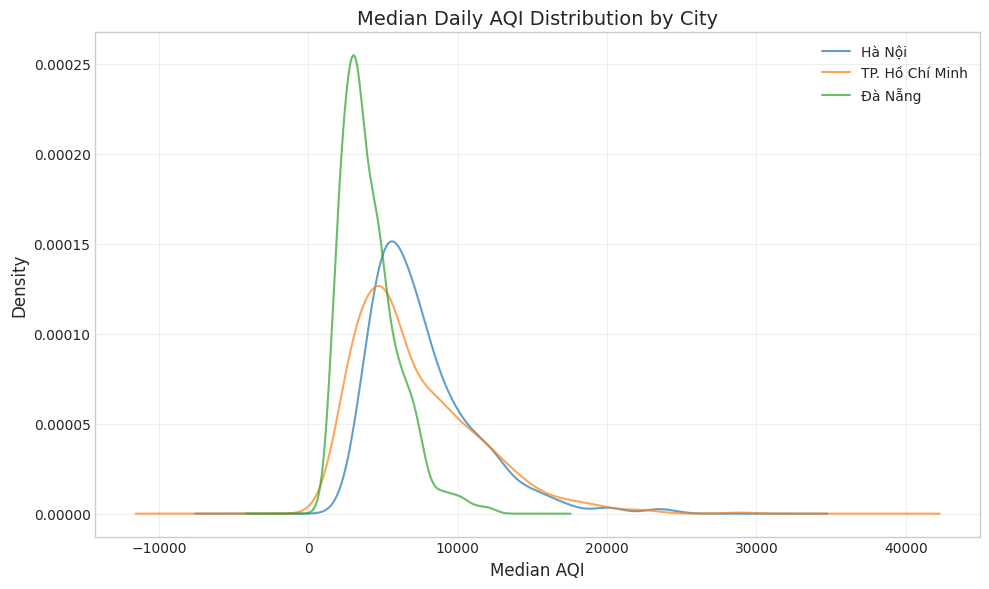

✅ Median AQI distribution plot saved


In [19]:
# Plot 1: Median AQI distributions (KDE)
print("Creating median AQI distribution plot...")
fig, ax = plt.subplots(figsize=(10, 6))
for city, group in daily_pd.groupby('location_name'):
    group['median_aqi'].plot(kind='kde', ax=ax, label=city, alpha=0.7)
ax.set_title('Median Daily AQI Distribution by City')
ax.set_xlabel('Median AQI')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(FIG_DIR / 'median_aqi_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close(fig)
print("✅ Median AQI distribution plot saved")

In [20]:
# Seasonal patterns analysis
print("Computing seasonal patterns...")
seasonal_stats = (
    daily_pd.groupby(['location_name', 'season'])['median_aqi']
    .agg(['median', 'mean', 'std', 'count']).reset_index()
)
seasonal_stats.columns = ['location_name', 'season', 'median_aqi', 'mean_aqi', 'std_aqi', 'days_count']

print("✅ Seasonal statistics computed")
display(seasonal_stats)

# Calculate seasonal change percentages
print("\nSeasonal change analysis:")
for city in daily_pd['location_name'].unique():
    city_seasonal = seasonal_stats[seasonal_stats['location_name'] == city]
    if len(city_seasonal) == 2:
        dry_median = city_seasonal[city_seasonal['season'] == 'Dry']['median_aqi'].iloc[0]
        rainy_median = city_seasonal[city_seasonal['season'] == 'Rainy']['median_aqi'].iloc[0]
        change_pct = ((rainy_median - dry_median) / dry_median) * 100
        print(f"{city}: Dry={dry_median:.0f}, Rainy={rainy_median:.0f} ({change_pct:+.1f}% change)")

Computing seasonal patterns...
✅ Seasonal statistics computed


,location_name,season,median_aqi,mean_aqi,std_aqi,days_count
0,Hà Nội,Dry,7217.5,8182.334437,3835.571154,302
1,Hà Nội,Rainy,6414.0,7115.335505,3009.552479,307
2,TP. Hồ Chí Minh,Dry,6113.0,7120.486755,4398.727495,302
3,TP. Hồ Chí Minh,Rainy,5689.0,7225.247557,3713.137179,307
4,Đà Nẵng,Dry,3925.5,4337.923841,2100.085297,302
5,Đà Nẵng,Rainy,3428.0,3909.114007,1655.048281,307



Seasonal change analysis:
Hà Nội: Dry=7218, Rainy=6414 (-11.1% change)
TP. Hồ Chí Minh: Dry=6113, Rainy=5689 (-6.9% change)
Đà Nẵng: Dry=3926, Rainy=3428 (-12.7% change)


In [21]:
# Convert hourly data for diurnal analysis (lighter operation)
print("Extracting hourly data for diurnal analysis...")
# Only get what we need to reduce memory
hourly_sample = analysis_df.select('location_name', 'hour', 'dow', 'season', 'aqi').sample(fraction=0.1, seed=42)
hourly_pd = hourly_sample.toPandas()
print(f"✅ Hourly sample extracted: {len(hourly_pd):,} rows (10% sample)")

Extracting hourly data for diurnal analysis...
✅ Hourly sample extracted: 4,359 rows (10% sample)
✅ Hourly sample extracted: 4,359 rows (10% sample)


In [22]:
# Step 1: Prepare data for diurnal pattern (lightweight operation)
print("📊 Preparing diurnal pattern data...")

# Small sample first to test
diurnal_profile = (
    hourly_pd
    .groupby(['location_name', 'hour'])['aqi']
    .median()
    .reset_index()
)

print(f"✅ Diurnal data prepared: {len(diurnal_profile)} data points")
print(f"Cities: {diurnal_profile['location_name'].unique()}")
print(f"Hours: {diurnal_profile['hour'].min()}-{diurnal_profile['hour'].max()}")

# Show sample
display(diurnal_profile.head(10))

📊 Preparing diurnal pattern data...
✅ Diurnal data prepared: 72 data points
Cities: ['Hà Nội' 'TP. Hồ Chí Minh' 'Đà Nẵng']
Hours: 0-23


,location_name,hour,aqi
0,Hà Nội,0,5903.0
1,Hà Nội,1,5921.0
2,Hà Nội,2,6737.0
3,Hà Nội,3,6532.0
4,Hà Nội,4,5707.0
5,Hà Nội,5,5829.0
6,Hà Nội,6,6663.0
7,Hà Nội,7,6558.0
8,Hà Nội,8,5881.0
9,Hà Nội,9,4755.0


🎨 Creating diurnal pattern plot...
   - Plotted Hà Nội: 24 points
   - Plotted TP. Hồ Chí Minh: 24 points
   - Plotted Đà Nẵng: 24 points
✅ Plot created successfully


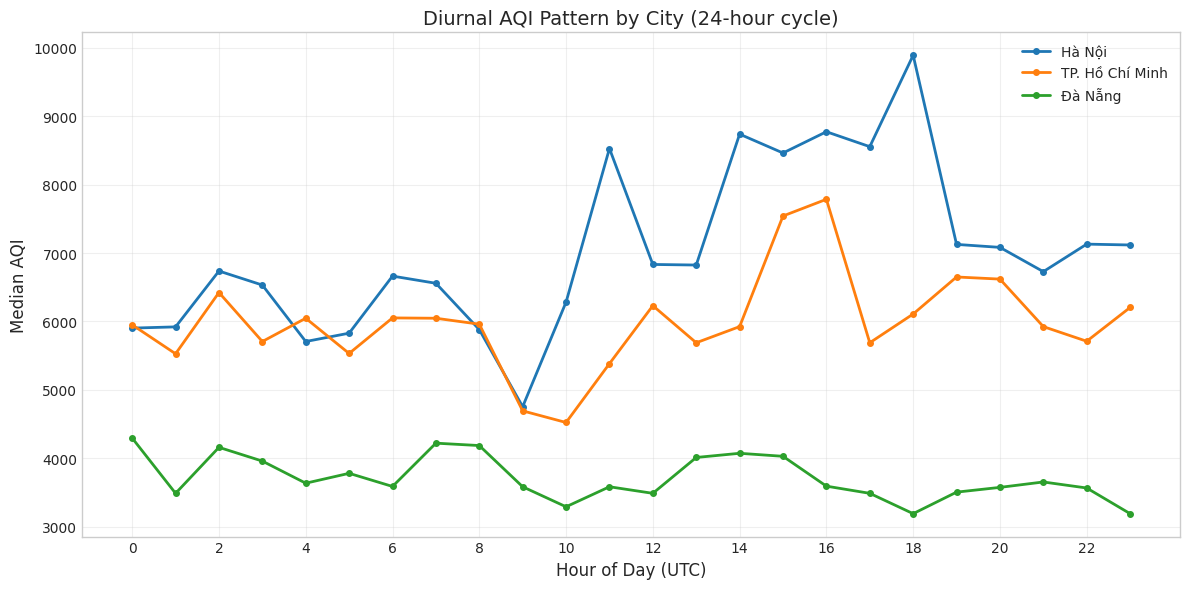

In [23]:
# Step 2: Create diurnal pattern plot (separated to reduce memory load)
print("🎨 Creating diurnal pattern plot...")

try:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot each city separately to control memory usage
    for city, group in diurnal_profile.groupby('location_name'):
        ax.plot(group['hour'], group['aqi'], 
                marker='o', label=city, linewidth=2, markersize=4)
        print(f"   - Plotted {city}: {len(group)} points")
    
    # Configure plot
    ax.set_xticks(range(0, 24, 2))
    ax.set_xlabel('Hour of Day (UTC)')
    ax.set_ylabel('Median AQI')
    ax.set_title('Diurnal AQI Pattern by City (24-hour cycle)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    fig.tight_layout()
    print("✅ Plot created successfully")
    
except Exception as e:
    print(f"❌ Error creating plot: {e}")
    fig, ax = None, None

In [24]:
# Step 3: Save and display plot (final step)
if fig is not None:
    try:
        # Save plot
        fig.savefig(FIG_DIR / 'diurnal_median_aqi.png', dpi=150, bbox_inches='tight')
        print("💾 Plot saved to diurnal_median_aqi.png")
        
        # Display plot
        plt.show()
        print("📈 Plot displayed successfully")
        
        # Clean up memory
        plt.close(fig)
        print("🧹 Memory cleaned up")
        
    except Exception as e:
        print(f"❌ Error saving/displaying plot: {e}")
        plt.close(fig)
else:
    print("⚠️  No plot to save (creation failed)")

print("✅ Diurnal pattern analysis complete")

💾 Plot saved to diurnal_median_aqi.png
📈 Plot displayed successfully
🧹 Memory cleaned up
✅ Diurnal pattern analysis complete


🎨 Creating diurnal pattern plot...
💾 Saving plot...


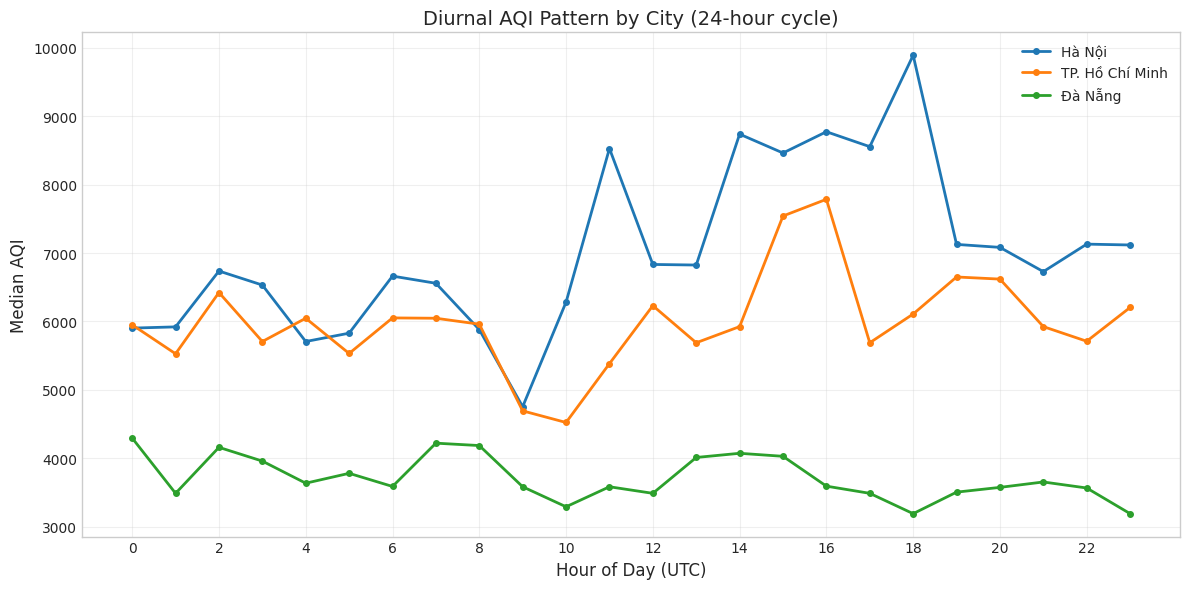

✅ Diurnal pattern plot saved successfully


In [25]:
# Step 2: Create diurnal pattern plot
print("🎨 Creating diurnal pattern plot...")

fig, ax = plt.subplots(figsize=(12, 6))
for city, group in diurnal_profile.groupby('location_name'):
    ax.plot(group['hour'], group['aqi'], marker='o', label=city, linewidth=2, markersize=4)

ax.set_xticks(range(0, 24, 2))
ax.set_xlabel('Hour of Day (UTC)')
ax.set_ylabel('Median AQI')
ax.set_title('Diurnal AQI Pattern by City (24-hour cycle)')
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()

print("💾 Saving plot...")
fig.savefig(FIG_DIR / 'diurnal_median_aqi.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close(fig)
print("✅ Diurnal pattern plot saved successfully")

In [26]:
# Lightweight execution control (run this before diagnostic/aggregation steps)
# Set LIGHTWEIGHT_MODE=True to use sampling/limits instead of full scans
LIGHTWEIGHT_MODE = True  # set False to run exact (may be slow)
SAMPLE_FRAC = 0.10       # fraction to sample when estimating counts (e.g., 0.05..0.2)
REDUCE_SHUFFLE_PARTITIONS = "8"  # reduces shuffle parallelism for small notebook runs

print(f"Lightweight mode: {LIGHTWEIGHT_MODE}; sample_frac={SAMPLE_FRAC}; shuffle_parts={REDUCE_SHUFFLE_PARTITIONS}")

# Helper function used by downstream cells
def apply_lightweight_settings():
    try:
        if LIGHTWEIGHT_MODE and REDUCE_SHUFFLE_PARTITIONS:
            _prev = spark.conf.get("spark.sql.shuffle.partitions", None)
            spark.conf.set("spark.sql.shuffle.partitions", REDUCE_SHUFFLE_PARTITIONS)
            print("Applied lightweight spark settings (reduced shuffle partitions)")
            return _prev
    except Exception as e:
        print("Could not apply lightweight settings:", e)
    return None

# Helper to restore previous setting
def restore_shuffle_partitions(prev):
    try:
        if prev is not None:
            spark.conf.set("spark.sql.shuffle.partitions", prev)
            print("Restored spark.sql.shuffle.partitions to previous value")
    except Exception as e:
        print("Could not restore shuffle partitions:", e)

# Small note for users
print("Run this cell before heavy diagnostic cells if you want a faster, sample-based run.")

Lightweight mode: True; sample_frac=0.1; shuffle_parts=8
Run this cell before heavy diagnostic cells if you want a faster, sample-based run.


In [27]:
# Step 3: Quick data inspection (optional - run if you want to see the data)
print("📋 Quick inspection of diurnal data:")
print(f"Shape: {diurnal_profile.shape}")
print("\nSample data:")
print(diurnal_profile.head(10))
print(f"\nAQI range: {diurnal_profile['aqi'].min():.1f} - {diurnal_profile['aqi'].max():.1f}")
print(f"Hours covered: {sorted(diurnal_profile['hour'].unique())}")

📋 Quick inspection of diurnal data:
Shape: (72, 3)

Sample data:
  location_name  hour     aqi
0        Hà Nội     0  5903.0
1        Hà Nội     1  5921.0
2        Hà Nội     2  6737.0
3        Hà Nội     3  6532.0
4        Hà Nội     4  5707.0
5        Hà Nội     5  5829.0
6        Hà Nội     6  6663.0
7        Hà Nội     7  6558.0
8        Hà Nội     8  5881.0
9        Hà Nội     9  4755.0

AQI range: 3192.0 - 9889.5
Hours covered: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


Creating AQI heatmaps by city...
Found 3 cities: TP. Hồ Chí Minh, Hà Nội, Đà Nẵng
Processing heatmap 1/3: TP. Hồ Chí Minh


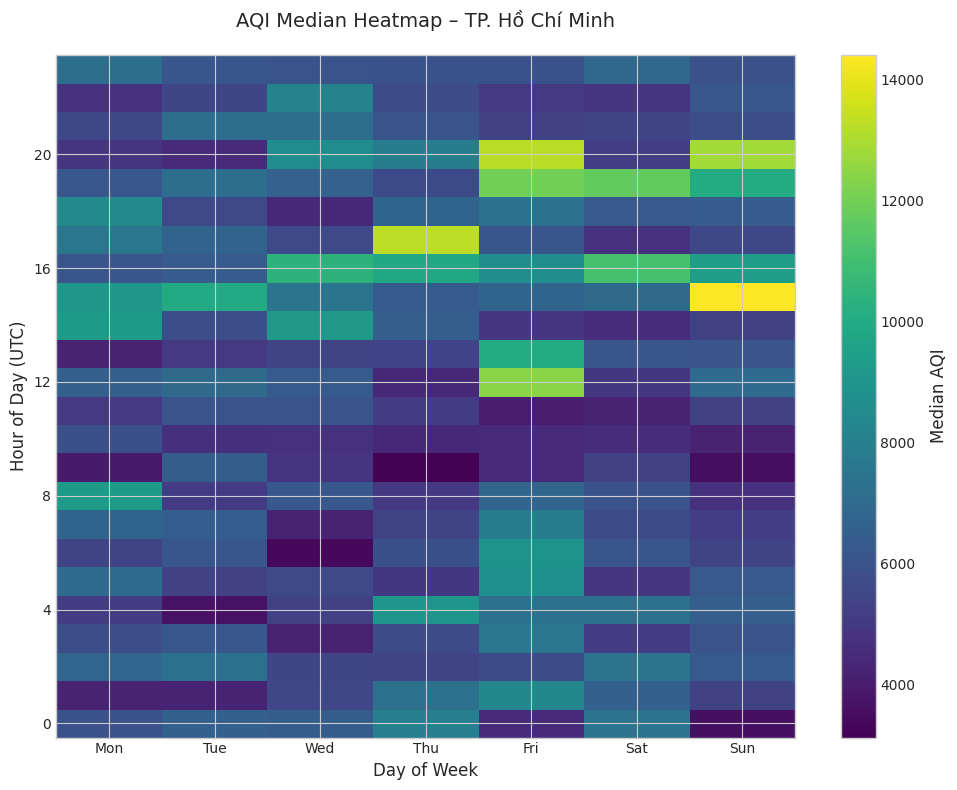

✅ Saved: aqi_heatmap_tp_hồ_chí_minh.png
Processing heatmap 2/3: Hà Nội


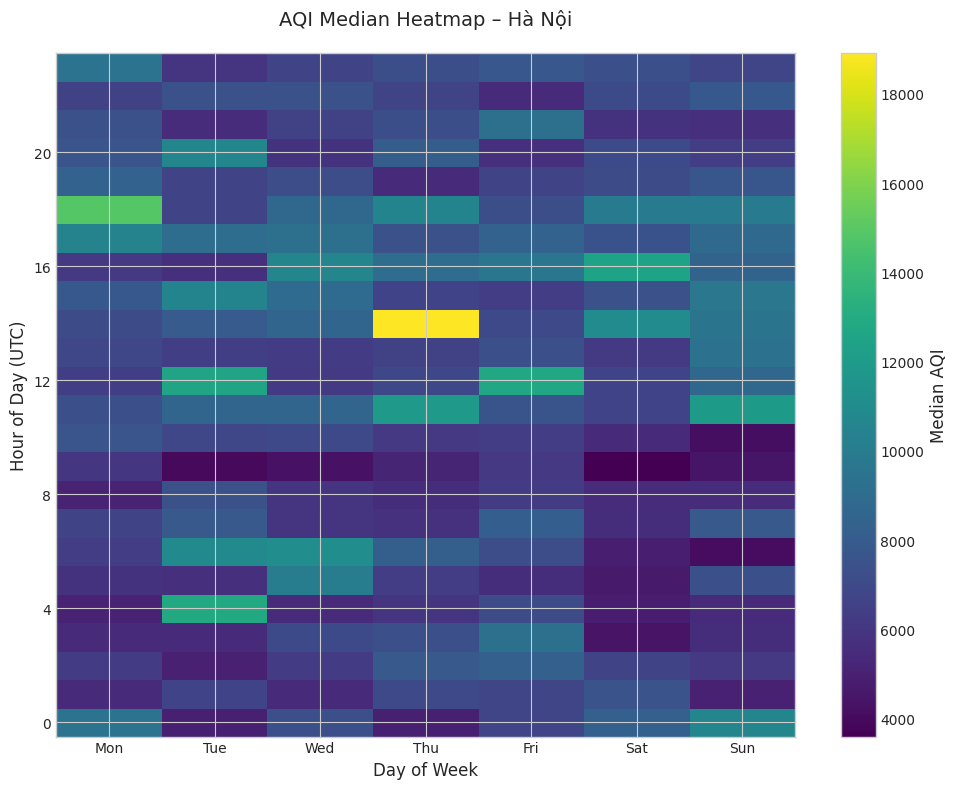

✅ Saved: aqi_heatmap_hà_nội.png
Processing heatmap 3/3: Đà Nẵng


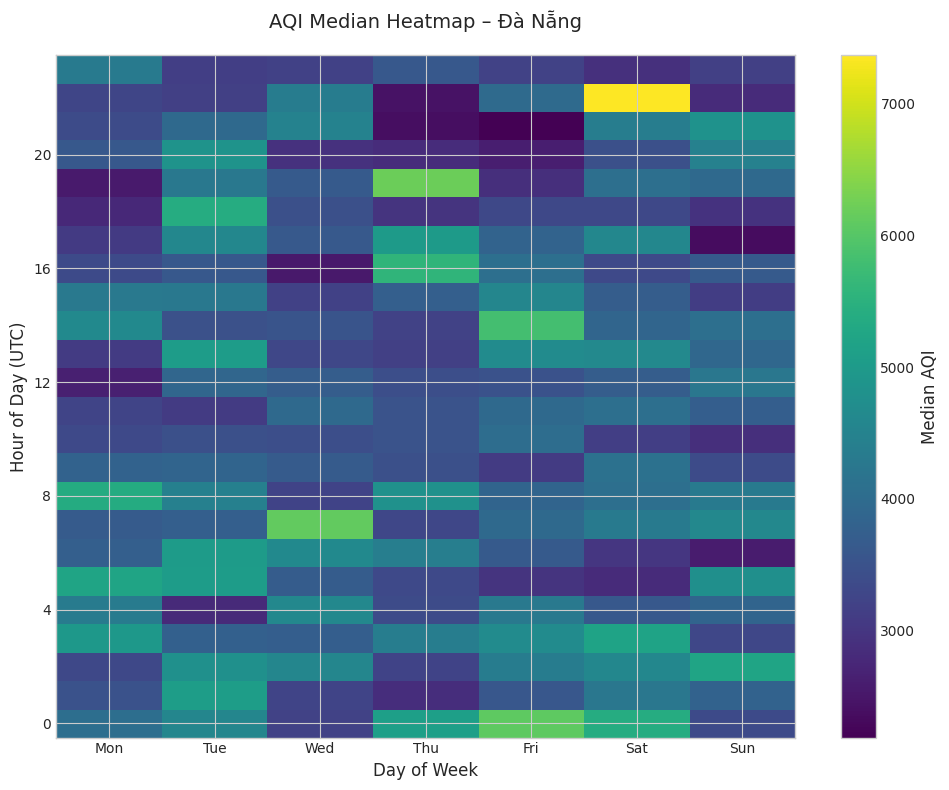

✅ Saved: aqi_heatmap_đà_nẵng.png
✅ All heatmaps completed


In [28]:
# Plot 3: Heatmaps (hour vs day-of-week) - one city at a time
print("Creating AQI heatmaps by city...")

cities = hourly_pd['location_name'].unique()
print(f"Found {len(cities)} cities: {', '.join(cities)}")

for i, city in enumerate(cities):
    print(f"Processing heatmap {i+1}/{len(cities)}: {city}")
    
    city_data = hourly_pd[hourly_pd['location_name'] == city]
    pivot = city_data.pivot_table(index='hour', columns='dow', values='aqi', aggfunc='median')
    
    # Handle missing data gracefully
    if pivot.empty:
        print(f"⚠️ No data available for {city}, skipping heatmap")
        continue
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(pivot.values, aspect='auto', origin='lower', cmap='viridis', interpolation='nearest')
    
    # Formatting
    ax.set_title(f'AQI Median Heatmap – {city}', fontsize=14, pad=20)
    ax.set_xlabel('Day of Week', fontsize=12)
    ax.set_ylabel('Hour of Day (UTC)', fontsize=12)
    
    # Set ticks and labels
    if pivot.shape[1] > 0:  # Check if we have columns
        ax.set_xticks(range(pivot.shape[1]))
        ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][:pivot.shape[1]])
    
    if pivot.shape[0] > 0:  # Check if we have rows
        ax.set_yticks(range(0, pivot.shape[0], 4))  # Every 4 hours
        ax.set_yticklabels(range(0, 24, 4))
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, label='Median AQI')
    
    fig.tight_layout()
    
    # Safe filename
    safe_city = city.lower().replace(" ", "_").replace(".", "")
    filename = f'aqi_heatmap_{safe_city}.png'
    fig.savefig(FIG_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"✅ Saved: {filename}")

print("✅ All heatmaps completed")

## 7. Diagnostic Analytics

In [29]:
# Part 1: Dominant pollutant distribution (lightweight)
print("📊 Analyzing dominant pollutant distribution...")

pollutant_dominance = (
    analysis_df
    .groupBy('location_name', 'dominant_pollutant')
    .agg(F.count('*').alias('hours'))
    .withColumn('share', F.col('hours') / F.sum('hours').over(Window.partitionBy('location_name')))
    .orderBy('location_name', F.desc('hours'))
)

print("✅ Pollutant dominance computed, displaying results...")
display(pollutant_dominance.toPandas())

📊 Analyzing dominant pollutant distribution...
✅ Pollutant dominance computed, displaying results...


,location_name,dominant_pollutant,hours,share
0,Hà Nội,co,14611,0.999658
1,Hà Nội,so2,5,0.000342
2,TP. Hồ Chí Minh,co,14611,0.999658
3,TP. Hồ Chí Minh,so2,5,0.000342
4,Đà Nẵng,co,14611,0.999658
5,Đà Nẵng,no2,4,0.000274
6,Đà Nẵng,so2,1,0.000068


In [30]:
# Step 2A: Prepare daily exceedance flags (lightweight)
print("📈 Analyzing PM2.5 exceedance streaks...")
print("Step 1: Preparing daily exceedance flags...")

daily_exceedance = (
    daily_df
    .withColumn('pm25_exceed_flag', F.col('pm25_exceed_hours_35') > 0)
    .select('location_key', 'location_name', 'date_utc', 'pm25_exceed_flag', 'pm25_exceed_hours_35')
)

print("✅ Exceedance flags created")
print(f"Rows processed: {daily_exceedance.count():,}")

# Quick inspection
sample_exceedance = daily_exceedance.limit(5).toPandas()
print("\n📋 Sample exceedance data:")
display(sample_exceedance)

📈 Analyzing PM2.5 exceedance streaks...
Step 1: Preparing daily exceedance flags...
✅ Exceedance flags created


Rows processed: 1,827



📋 Sample exceedance data:


,location_key,location_name,date_utc,pm25_exceed_flag,pm25_exceed_hours_35
0,Hà Nội,Hà Nội,2024-06-01,True,24
1,TP. Hồ Chí Minh,TP. Hồ Chí Minh,2025-05-29,True,16
2,TP. Hồ Chí Minh,TP. Hồ Chí Minh,2024-09-15,False,0
3,Hà Nội,Hà Nội,2024-02-20,True,6
4,TP. Hồ Chí Minh,TP. Hồ Chí Minh,2024-04-08,False,0


In [31]:
# Step 2B: Compute consecutive streaks (medium weight)
print("📊 Step 2: Computing consecutive exceedance streaks...")

# Define window for row numbering
window = Window.partitionBy('location_key').orderBy('date_utc')

print("⚙️  Creating window functions...")
exceedance_with_index = (
    daily_exceedance
    .withColumn('row_id', F.row_number().over(window))
    .withColumn('exceed_cumsum', F.sum(F.col('pm25_exceed_flag').cast('int')).over(window))
    .withColumn('exceed_group', F.col('row_id') - F.col('exceed_cumsum'))
)

print("✅ Streak groups computed")

# Cache for next step since we'll use it again
exceedance_with_index = exceedance_with_index.cache()
print(f"Indexed rows: {exceedance_with_index.count():,}")

# Quick sample
print("\n📋 Sample indexed data:")
sample_indexed = exceedance_with_index.filter(F.col('pm25_exceed_flag')).limit(3).toPandas()
display(sample_indexed)

📊 Step 2: Computing consecutive exceedance streaks...
⚙️  Creating window functions...
✅ Streak groups computed


Indexed rows: 1,827

📋 Sample indexed data:


,location_key,location_name,date_utc,pm25_exceed_flag,pm25_exceed_hours_35,row_id,exceed_cumsum,exceed_group
0,Đà Nẵng,Đà Nẵng,2024-02-13,True,3,44,1,43
1,Đà Nẵng,Đà Nẵng,2024-03-05,True,4,65,2,63
2,Đà Nẵng,Đà Nẵng,2024-03-06,True,18,66,3,63


In [32]:
# Step 2C1: Create streak aggregation (optimized for performance)
print("Step 3A: Creating streak aggregation (optimized)...")

# Check if required variables exist
if 'exceedance_with_index' not in globals():
    print("❌ Error: 'exceedance_with_index' not found. Please run the previous streak preparation cell first.")
else:
    try:
        # Apply lightweight settings if available
        prev_shuffle = None
        if 'LIGHTWEIGHT_MODE' in globals() and LIGHTWEIGHT_MODE:
            if 'apply_lightweight_settings' in globals():
                prev_shuffle = apply_lightweight_settings()
            else:
                # Set reduced shuffle partitions directly
                prev_shuffle = spark.conf.get("spark.sql.shuffle.partitions", "200")
                spark.conf.set("spark.sql.shuffle.partitions", "8")
                print("Applied lightweight shuffle partitions: 8")

        # Repartition by grouping keys to reduce shuffle during groupBy
        print("Repartitioning data by grouping keys...")
        optimized_df = exceedance_with_index.repartition("location_key", "exceed_group")
        
        # Create aggregation WITHOUT expensive global orderBy
        streaks = (
            optimized_df
            .where(F.col('pm25_exceed_flag'))
            .groupBy('location_key', 'location_name', 'exceed_group')
            .agg(
                F.min('date_utc').alias('streak_start'),
                F.max('date_utc').alias('streak_end'),
                F.count('*').alias('days_in_streak'),
                F.sum('pm25_exceed_hours_35').alias('total_exceed_hours'),
            )
            # No global orderBy here - defer sorting to display step
        )

        # Define helper function for efficient top-N retrieval
        def get_top_streaks(df, n=10):
            """Get top N streaks efficiently without expensive global sort"""
            try:
                # For small datasets, use simple approach
                approx_count = df.count()
                if approx_count <= 1000:
                    return df.orderBy(F.desc('days_in_streak')).limit(n)
                
                # For larger datasets, get top per location then global top
                per_location_top = (
                    df.withColumn('rn', F.row_number().over(
                        Window.partitionBy('location_key').orderBy(F.desc('days_in_streak'))
                    ))
                    .where(F.col('rn') <= 5)  # Top 5 per location
                    .drop('rn')
                )
                return per_location_top.orderBy(F.desc('days_in_streak')).limit(n)
            except Exception:
                # Fallback to simple approach
                return df.orderBy(F.desc('days_in_streak')).limit(n)

        print("✅ Streak aggregation created (optimized, not materialized yet)")
        print("✅ Helper function 'get_top_streaks(streaks, n=10)' available for efficient display")
        print("⚡ Ready for next step: count and display (should be much faster now)")
        
        # Restore shuffle partitions if changed
        if prev_shuffle and 'restore_shuffle_partitions' in globals():
            restore_shuffle_partitions(prev_shuffle)
        elif prev_shuffle:
            spark.conf.set("spark.sql.shuffle.partitions", prev_shuffle)
            print("Restored previous shuffle partitions")
            
    except Exception as e:
        print(f"❌ Error during streak aggregation: {e}")
        print("💡 Try running previous cells to ensure 'exceedance_with_index' is properly created")
        raise

Step 3A: Creating streak aggregation (optimized)...
Applied lightweight spark settings (reduced shuffle partitions)
Repartitioning data by grouping keys...
✅ Streak aggregation created (optimized, not materialized yet)
✅ Helper function 'get_top_streaks(streaks, n=10)' available for efficient display
⚡ Ready for next step: count and display (should be much faster now)


In [34]:
# Step 2C2: Count streaks (lightweight check)
print("📈 Step 3B: Counting total streaks...")

streak_count = streaks.count()
print(f"📊 Total exceedance streaks found: {streak_count}")

if streak_count > 0:
    print("✅ Streaks found! Ready to display results")
else:
    print("⚠️  No exceedance streaks found in the data")
    print("🔍 This means no days had PM2.5 > 35 µg/m³")

📈 Step 3B: Counting total streaks...
📊 Total exceedance streaks found: 166
✅ Streaks found! Ready to display results
📊 Total exceedance streaks found: 166
✅ Streaks found! Ready to display results


In [35]:
# Step 2C3: Display top streaks (only if data exists)
if 'streak_count' in locals() and streak_count > 0:
    print("🏆 Displaying top 10 exceedance streaks...")
    
    # Get top 10 streaks
    top_streaks = streaks.limit(10).toPandas()
    print(f"Showing top {len(top_streaks)} streaks:")
    display(top_streaks)
    
    print("✅ Top streaks displayed successfully")
else:
    print("⚠️  No streaks to display (streak_count = 0 or not computed)")
    print("💡 Run the previous cell first to count streaks")

🏆 Displaying top 10 exceedance streaks...
Showing top 10 streaks:
Showing top 10 streaks:


,location_key,location_name,exceed_group,streak_start,streak_end,days_in_streak,total_exceed_hours
0,Đà Nẵng,Đà Nẵng,84,2024-03-31,2024-04-01,2,10
1,Đà Nẵng,Đà Nẵng,85,2024-04-03,2024-04-03,1,7
2,Đà Nẵng,Đà Nẵng,126,2024-05-26,2024-05-30,5,28
3,Đà Nẵng,Đà Nẵng,161,2024-07-22,2024-07-22,1,2
4,Đà Nẵng,Đà Nẵng,154,2024-07-09,2024-07-10,2,4
5,Đà Nẵng,Đà Nẵng,162,2024-07-24,2024-07-24,1,1
6,Đà Nẵng,Đà Nẵng,357,2025-03-18,2025-03-22,5,47
7,Đà Nẵng,Đà Nẵng,388,2025-06-05,2025-06-06,2,7
8,Đà Nẵng,Đà Nẵng,155,2024-07-12,2024-07-13,2,8
9,Đà Nẵng,Đà Nẵng,176,2024-08-22,2024-08-26,5,24


✅ Top streaks displayed successfully


In [36]:
# Step 2C4: Summary by city & cleanup (final step)
if 'streak_count' in locals() and streak_count > 0:
    print("📊 Creating summary statistics by city...")
    
    streak_summary = (
        streaks
        .groupBy('location_name')
        .agg(
            F.count('*').alias('total_streaks'),
            F.max('days_in_streak').alias('longest_streak'),
            F.avg('days_in_streak').alias('avg_streak_length'),
            F.sum('total_exceed_hours').alias('total_exceed_hours')
        )
        .orderBy(F.desc('longest_streak'))
    )
    
    print("📈 Streak summary by city:")
    display(streak_summary.toPandas())
    print("✅ Summary complete!")
else:
    print("⚠️  No summary to create (no streaks found)")

# Clean up cache
print("\n🧹 Cleaning up memory...")
try:
    exceedance_with_index.unpersist()
    print("✅ Cache cleared successfully")
except:
    print("⚠️  Cache was already cleared or not found")

print("🎉 Exceedance analysis complete!")

📊 Creating summary statistics by city...
📈 Streak summary by city:


,location_name,total_streaks,longest_streak,avg_streak_length,total_exceed_hours
0,Hà Nội,44,113,12.227273,8326
1,TP. Hồ Chí Minh,61,63,5.819672,3118
2,Đà Nẵng,61,9,2.409836,922


✅ Summary complete!

🧹 Cleaning up memory...
✅ Cache cleared successfully
🎉 Exceedance analysis complete!


In [37]:
# Part 3: Correlation analysis (can be heavy - runs for each city)
print("📊 Analyzing correlations between AQI and pollutant components...")

# Get list of cities first
cities = analysis_df.select('location_name').distinct().toPandas()['location_name'].tolist()
print(f"Cities to analyze: {cities}")

correlation_stats = []
for i, city in enumerate(cities, 1):
    print(f"  Processing city {i}/{len(cities)}: {city}")
    try:
        city_df = analysis_df.where(F.col('location_name') == city).select('aqi', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co')
        corr_row = {'location_name': city}
        
        for col in ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']:
            corr_value = city_df.corr('aqi', col)
            corr_row[f'corr_aqi_{col}'] = corr_value
            
        correlation_stats.append(corr_row)
        print(f"    ✅ {city} completed")
    except Exception as e:
        print(f"    ❌ Error with {city}: {e}")

print("\n✅ Correlation analysis complete, displaying results...")
correlation_df = pd.DataFrame(correlation_stats)
display(correlation_df)

📊 Analyzing correlations between AQI and pollutant components...


Cities to analyze: ['Hà Nội', 'TP. Hồ Chí Minh', 'Đà Nẵng']
  Processing city 1/3: Hà Nội


    ✅ Hà Nội completed
  Processing city 2/3: TP. Hồ Chí Minh


    ✅ TP. Hồ Chí Minh completed
  Processing city 3/3: Đà Nẵng


    ✅ Đà Nẵng completed

✅ Correlation analysis complete, displaying results...


,location_name,corr_aqi_pm25,corr_aqi_pm10,corr_aqi_o3,corr_aqi_no2,corr_aqi_so2,corr_aqi_co
0,Hà Nội,0.511895,0.471597,-0.184151,0.491369,0.463661,0.748323
1,TP. Hồ Chí Minh,0.584914,0.441530,-0.204721,0.580576,0.179309,0.757147
2,Đà Nẵng,0.287094,0.096891,0.119548,0.293258,-0.168913,0.790844


## 8. Statistical Inference

In [38]:
# Bootstrap 95% CI for median AQI per city
rng = np.random.default_rng(42)
bootstrap_records = []
boot_iterations = 1000

for city, group in daily_pd.groupby('location_name'):
    values = group['median_aqi'].dropna().values
    if len(values) == 0:
        continue
    bootstrap_samples = rng.choice(values, size=(boot_iterations, len(values)), replace=True)
    medians = np.median(bootstrap_samples, axis=1)
    lower, upper = np.percentile(medians, [2.5, 97.5])
    bootstrap_records.append({
        'location_name': city,
        'median_point_estimate': np.median(values),
        'ci_lower_95': lower,
        'ci_upper_95': upper,
    })

bootstrap_df = pd.DataFrame(bootstrap_records)
display(bootstrap_df)

# Mann–Whitney U test (Dry vs Rainy season)
try:
    from scipy.stats import mannwhitneyu
except ModuleNotFoundError:
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scipy==1.11.4'])
    from scipy.stats import mannwhitneyu

mann_records = []
for city, group in daily_pd.groupby('location_name'):
    dry = group.loc[group['season'] == 'Dry', 'median_aqi'].dropna().values
    rainy = group.loc[group['season'] == 'Rainy', 'median_aqi'].dropna().values
    if len(dry) == 0 or len(rainy) == 0:
        continue
    stat, p_value = mannwhitneyu(dry, rainy, alternative='two-sided')
    mann_records.append({
        'location_name': city,
        'dry_median': np.median(dry),
        'rainy_median': np.median(rainy),
        'p_value': p_value,
    })

mann_df = pd.DataFrame(mann_records)
display(mann_df)


,location_name,median_point_estimate,ci_lower_95,ci_upper_95
0,Hà Nội,6755.0,6484.0,7078.0
1,TP. Hồ Chí Minh,5916.0,5611.0,6336.0
2,Đà Nẵng,3585.0,3471.0,3864.0


,location_name,dry_median,rainy_median,p_value
0,Hà Nội,7217.5,6414.0,0.001056
1,TP. Hồ Chí Minh,6113.0,5689.0,0.194583
2,Đà Nẵng,3925.5,3428.0,0.044118


## 9. Anomaly Detection

In [39]:
# Robust z-score using IQR per (location, hour)
quantiles = (
    analysis_df
    .groupBy('location_key', 'location_name', 'hour')
    .agg(
        F.expr('percentile_approx(aqi, 0.25, 1000)').alias('q1'),
        F.expr('percentile_approx(aqi, 0.5, 1000)').alias('median'),
        F.expr('percentile_approx(aqi, 0.75, 1000)').alias('q3'),
    )
    .withColumn('iqr', F.col('q3') - F.col('q1'))
)

anomaly_df = (
    analysis_df.alias('f')
    .join(quantiles.alias('q'), ['location_key', 'location_name', 'hour'], 'left')
    .withColumn('iqr_safe', F.when(F.col('q.iqr') < 1e-6, 1e-6).otherwise(F.col('q.iqr')))
    .withColumn('robust_z', (F.col('f.aqi') - F.col('q.median')) / (F.col('iqr_safe') / F.lit(1.349)))
    .withColumn('abs_robust_z', F.abs(F.col('robust_z')))
)

# Safely compute threshold, handling empty DataFrames
threshold_result = anomaly_df.approxQuantile('abs_robust_z', [0.99], 0.01)
if threshold_result and len(threshold_result) > 0:
    threshold = threshold_result[0]
else:
    # Fallback if no data
    import warnings
    warnings.warn("No data available for anomaly detection; using default threshold=3.0")
    threshold = 3.0

spikes = (
    anomaly_df
    .where(F.col('abs_robust_z') >= F.lit(threshold))
    .select(
        'location_name', 'ts_utc', 'aqi', 'robust_z', 'abs_robust_z', 'dominant_pollutant', 'is_validated', 'quality_flag'
    )
    .orderBy(F.desc('abs_robust_z'))
)

spike_pd = spikes.limit(200).toPandas()
display(spike_pd)


,location_name,ts_utc,aqi,robust_z,abs_robust_z,dominant_pollutant,is_validated,quality_flag
0,TP. Hồ Chí Minh,2025-01-15 22:00:00,50503.0,10.840074,10.840074,co,True,validated


## 10. Nowcasting Model (1–6 h Horizons)

In [42]:
# Feature engineering for modelling
lag_window = Window.partitionBy('location_key').orderBy('ts_utc')
feature_df = (
    analysis_df
    .withColumn('lag_1_aqi', F.lag('aqi', 1).over(lag_window))
    .withColumn('lag_3_aqi', F.lag('aqi', 3).over(lag_window))
    .withColumn('lag_6_aqi', F.lag('aqi', 6).over(lag_window))
    .withColumn('lag_24_aqi', F.lag('aqi', 24).over(lag_window))
)

for horizon in range(1, 7):
    feature_df = feature_df.withColumn(f'lead_{horizon}_aqi', F.lead('aqi', horizon).over(lag_window))

stack_cols = [F.struct(F.lit(h).alias('horizon'), F.col(f'lead_{h}_aqi').alias('target_aqi')) for h in range(1, 7)]
model_df = (
    feature_df
    .withColumn('future_targets', F.array(*stack_cols))
    .withColumn('exploded', F.explode('future_targets'))
    .select(
        'location_key', 'location_name', 'ts_utc', 'date_utc', 'season', 'hour', 'dow', 'month',
        'aqi', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'is_validated', 'lag_1_aqi', 'lag_3_aqi', 'lag_6_aqi', 'lag_24_aqi',
        'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
        F.col('exploded.horizon').alias('horizon'),
        F.col('exploded.target_aqi').alias('target_aqi')
    )
    .where(F.col('target_aqi').isNotNull())
    .withColumn('is_validated', F.col('is_validated').cast('double'))
)

# Safely get max_date, handling empty/null results
max_date_result = model_df.agg(F.max('date_utc')).collect()[0][0]
if max_date_result is None:
    import warnings
    warnings.warn("No data available for nowcasting model; skipping train/test split.")
    train_df = model_df.limit(0)
    test_df = model_df.limit(0)
    print("Training rows: 0; Testing rows: 0")
else:
    max_date = max_date_result
    split_date = max_date - timedelta(days=30)
    
    train_df = model_df.where(F.col('date_utc') <= F.lit(split_date))
    test_df = model_df.where(F.col('date_utc') > F.lit(split_date))
    
    print(f"Training rows: {train_df.count():,}; Testing rows: {test_df.count():,}")


Training rows: 250,128; Testing rows: 12,897


🔧 Setting up ML pipeline with 250,128 training and 12,897 test samples...
🔍 Checking for NaN/null values in training data...


⚠️  Found 18 null/NaN values in 'lag_1_aqi'


⚠️  Found 54 null/NaN values in 'lag_3_aqi'


⚠️  Found 108 null/NaN values in 'lag_6_aqi'
🚀 Building and training pipeline...


✅ Model training completed successfully!


📊 Generated 12,897 predictions
📈 Overall RMSE: 2664.43; Overall MAE: 1401.90
📊 Computing metrics by city...
📈 Overall RMSE: 2664.43; Overall MAE: 1401.90
📊 Computing metrics by city...


,location_name,rmse,mae,prediction_count
0,Hà Nội,1978.848354,1247.769635,4299
1,TP. Hồ Chí Minh,4038.381899,2252.979496,4299
2,Đà Nẵng,1035.949434,704.954462,4299


📊 Computing metrics by forecast horizon...


,horizon,rmse,mae,prediction_count
0,1,2074.007802,998.657319,2157
1,2,2319.686483,1182.454293,2154
2,3,2590.718552,1378.056014,2151
3,4,2810.270110,1503.604413,2148
4,5,2917.695431,1604.225423,2145
5,6,3133.194589,1747.994895,2142


📈 Creating forecast error plot...


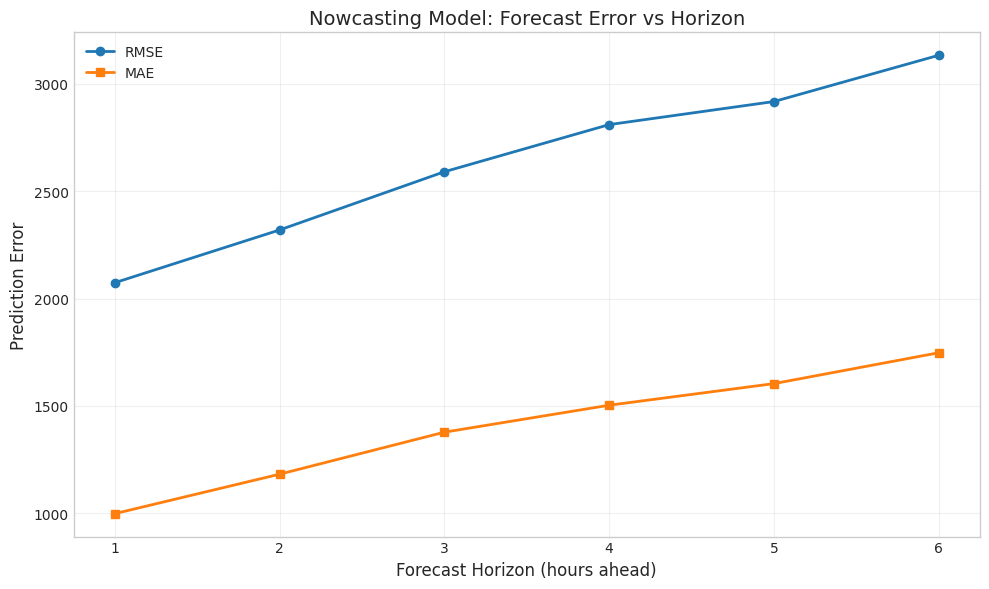

💾 Plot saved to forecast_error_vs_horizon.png


In [44]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Check for required variables
missing_vars = []
for var_name in ['train_df', 'test_df', 'F']:
    if var_name not in globals():
        missing_vars.append(var_name)

if missing_vars:
    print(f"❌ Missing required variables: {', '.join(missing_vars)}")
    print("Please run the feature engineering cell first to create train_df and test_df")
else:
    # Skip model training if no data available
    train_count = train_df.count()
    test_count = test_df.count()
    
    if train_count == 0 or test_count == 0:
        import warnings
        warnings.warn("Insufficient data for model training; skipping nowcasting model.")
        print("Skipping model training due to insufficient data.")
        print(f"Train rows: {train_count}, Test rows: {test_count}")
    else:
        print(f"🔧 Setting up ML pipeline with {train_count:,} training and {test_count:,} test samples...")
        
        try:
            # String indexers with proper invalid handling
            location_indexer = StringIndexer(inputCol='location_name', outputCol='location_index', handleInvalid='keep')
            season_indexer = StringIndexer(inputCol='season', outputCol='season_index', handleInvalid='keep')

            # Define feature columns
            feature_columns = [
                'aqi', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co',
                'lag_1_aqi', 'lag_3_aqi', 'lag_6_aqi', 'lag_24_aqi',
                'hour', 'dow', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
                'horizon', 'is_validated', 'location_index', 'season_index'
            ]

            # Check for NaN values before training
            print("🔍 Checking for NaN/null values in training data...")
            for col_name in feature_columns[:10]:  # Check first 10 columns as sample
                if col_name in train_df.columns:
                    null_count = train_df.filter(F.col(col_name).isNull() | F.isnan(F.col(col_name))).count()
                    if null_count > 0:
                        print(f"⚠️  Found {null_count} null/NaN values in '{col_name}'")

            # VectorAssembler with skip invalid values (safer than 'keep')
            assembler = VectorAssembler(
                inputCols=feature_columns, 
                outputCol='features', 
                handleInvalid='skip'  # Skip rows with invalid values instead of keeping them
            )

            # GBT Regressor with conservative parameters
            regressor = GBTRegressor(
                featuresCol='features',
                labelCol='target_aqi',
                maxIter=50,   # Reduced for faster training
                maxDepth=5,   # Reduced to prevent overfitting
                stepSize=0.1, # Slightly larger step size
                subsamplingRate=0.8,
                seed=42
            )

            print("🚀 Building and training pipeline...")
            pipeline = Pipeline(stages=[location_indexer, season_indexer, assembler, regressor])
            
            # Train the model
            model = pipeline.fit(train_df)
            print("✅ Model training completed successfully!")
            
            # Generate predictions
            predictions = model.transform(test_df).cache()
            pred_count = predictions.count()
            print(f"📊 Generated {pred_count:,} predictions")

            if pred_count > 0:
                # Evaluation metrics
                rmse_evaluator = RegressionEvaluator(labelCol='target_aqi', predictionCol='prediction', metricName='rmse')
                mae_evaluator = RegressionEvaluator(labelCol='target_aqi', predictionCol='prediction', metricName='mae')

                overall_rmse = rmse_evaluator.evaluate(predictions)
                overall_mae = mae_evaluator.evaluate(predictions)
                print(f"📈 Overall RMSE: {overall_rmse:.2f}; Overall MAE: {overall_mae:.2f}")

                # Metrics by city
                print("📊 Computing metrics by city...")
                metrics_by_city = (
                    predictions
                    .groupBy('location_name')
                    .agg(
                        F.sqrt(F.mean(F.pow(F.col('prediction') - F.col('target_aqi'), 2))).alias('rmse'),
                        F.mean(F.abs(F.col('prediction') - F.col('target_aqi'))).alias('mae'),
                        F.count('*').alias('prediction_count')
                    )
                    .toPandas()
                )
                display(metrics_by_city)

                # Metrics by horizon
                print("📊 Computing metrics by forecast horizon...")
                metrics_by_horizon = (
                    predictions
                    .groupBy('horizon')
                    .agg(
                        F.sqrt(F.mean(F.pow(F.col('prediction') - F.col('target_aqi'), 2))).alias('rmse'),
                        F.mean(F.abs(F.col('prediction') - F.col('target_aqi'))).alias('mae'),
                        F.count('*').alias('prediction_count')
                    )
                    .orderBy('horizon')
                    .toPandas()
                )
                display(metrics_by_horizon)

                # Create visualization
                print("📈 Creating forecast error plot...")
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.plot(metrics_by_horizon['horizon'], metrics_by_horizon['rmse'], marker='o', label='RMSE', linewidth=2)
                ax.plot(metrics_by_horizon['horizon'], metrics_by_horizon['mae'], marker='s', label='MAE', linewidth=2)
                ax.set_xlabel('Forecast Horizon (hours ahead)')
                ax.set_ylabel('Prediction Error')
                ax.set_title('Nowcasting Model: Forecast Error vs Horizon')
                ax.legend()
                ax.grid(True, alpha=0.3)
                fig.tight_layout()
                fig.savefig(FIG_DIR / 'forecast_error_vs_horizon.png', dpi=150, bbox_inches='tight')
                plt.show()
                plt.close(fig)
                print("💾 Plot saved to forecast_error_vs_horizon.png")
            else:
                print("⚠️  No predictions generated - check data quality and feature engineering")
                
        except Exception as e:
            print(f"❌ Model training failed: {e}")
            print("🔍 Diagnostic information:")
            
            # Show sample of training data for debugging
            print("\nSample training data (first 5 rows, first 10 columns):")
            sample_cols = feature_columns[:10] + ['target_aqi']
            available_cols = [c for c in sample_cols if c in train_df.columns]
            if available_cols:
                sample_data = train_df.select(*available_cols).limit(5).toPandas()
                display(sample_data)
            else:
                print("No feature columns found in train_df")
            
            # Re-raise for debugging
            raise

## 11. Sensitivity Analysis

In [46]:
def compute_kpis(df):
    return (
        df
        .groupby('location_name')
        .agg(
            median_aqi=('median_aqi', 'median'),
            mean_aqi=('mean_aqi', 'mean'),
            pm25_exceed_days=('pm25_exceed_flag', 'sum'),
            total_days=('pm25_exceed_flag', 'count'),
            completeness=('aqi_completeness', 'mean'),
        )
        .assign(pm25_exceed_rate=lambda d: d['pm25_exceed_days'] / d['total_days'] if d['total_days'].sum() > 0 else 0)
        .reset_index()
    )

scenarios = []

# Only run sensitivity analysis if we have data
if len(daily_pd) > 0:
    for threshold in [25, 35, 50]:
        temp = daily_pd.copy()
        temp['pm25_exceed_flag'] = temp[f'pm25_exceed_hours_{threshold}'] > 0
        temp_kpi = compute_kpis(temp)
        temp_kpi['scenario'] = f'pm25_threshold_{threshold}'
        scenarios.append(temp_kpi)

    cutoff = daily_pd['median_aqi'].quantile(0.99)
    filtered = daily_pd[daily_pd['median_aqi'] <= cutoff].copy()
    filtered['pm25_exceed_flag'] = filtered['pm25_exceed_hours_35'] > 0
    filtered_kpi = compute_kpis(filtered)
    filtered_kpi['scenario'] = 'remove_top_1pct_spikes'
    scenarios.append(filtered_kpi)

    # Fix: Add mean_aqi calculation to validated_daily
    validated_daily = (
        analysis_df
        .where(F.col('is_validated'))
        .groupBy('location_name', 'date_utc')
        .agg(F.expr('percentile_approx(aqi, 0.5, 1000)').alias('median_aqi_validated'),
             F.avg('aqi').alias('mean_aqi_validated'),  # Add mean calculation
             F.avg(F.when(F.col('aqi').isNotNull(), 1.0).otherwise(0.0)).alias('aqi_completeness'),
             F.sum(F.when(F.col('pm25') > 35, 1).otherwise(0)).alias('pm25_exceed_hours_35'))
        .withColumn('pm25_exceed_flag', F.col('pm25_exceed_hours_35') > 0)
    )
    validated_pd = validated_daily.toPandas()
    validated_pd.rename(columns={
        'median_aqi_validated': 'median_aqi',
        'mean_aqi_validated': 'mean_aqi'  # Also rename mean_aqi column
    }, inplace=True)
    validated_kpi = compute_kpis(validated_pd)
    validated_kpi['scenario'] = 'validated_only'
    scenarios.append(validated_kpi)

    sensitivity_df = pd.concat(scenarios, ignore_index=True)
    display(sensitivity_df)
else:
    import warnings
    warnings.warn("No data available for sensitivity analysis.")
    print("Skipping sensitivity analysis due to insufficient data.")

,location_name,median_aqi,mean_aqi,pm25_exceed_days,total_days,completeness,pm25_exceed_rate,scenario
0,Hà Nội,6755.0,8281.572523,586,609,1.0,0.962233,pm25_threshold_25
1,TP. Hồ Chí Minh,5916.0,7804.284962,483,609,1.0,0.793103,pm25_threshold_25
2,Đà Nẵng,3585.0,4277.153872,335,609,1.0,0.550082,pm25_threshold_25
3,Hà Nội,6755.0,8281.572523,538,609,1.0,0.883415,pm25_threshold_35
4,TP. Hồ Chí Minh,5916.0,7804.284962,355,609,1.0,0.582923,pm25_threshold_35
5,Đà Nẵng,3585.0,4277.153872,147,609,1.0,0.241379,pm25_threshold_35
6,Hà Nội,6755.0,8281.572523,423,609,1.0,0.694581,pm25_threshold_50
7,TP. Hồ Chí Minh,5916.0,7804.284962,179,609,1.0,0.293924,pm25_threshold_50
8,Đà Nẵng,3585.0,4277.153872,28,609,1.0,0.045977,pm25_threshold_50
9,Hà Nội,6719.5,8065.592153,530,600,1.0,0.883333,remove_top_1pct_spikes


## 12. Insights & Recommendations

In [47]:
# Helper summaries to feed narrative
latest_period = scope_summary.loc[0, 'max_ts_utc']

# Safely compute season/city metrics
if len(daily_pd) > 0:
    season_city = (
        daily_pd[daily_pd['season'] == 'Dry']
        .groupby('location_name')['median_aqi']
        .median()
        .sort_values(ascending=False)
    )
    worst_dry_city = season_city.index[0] if not season_city.empty else None
    worst_dry_value = season_city.iloc[0] if not season_city.empty else None
else:
    season_city = pd.Series(dtype=float)
    worst_dry_city = None
    worst_dry_value = None

# Use already computed pollutant_dominance (avoid calling toPandas on potentially broken Spark session)
try:
    pollutant_top = (pollutant_dominance
                     .withColumn('rank', F.row_number().over(Window.partitionBy('location_name').orderBy(F.desc('share'))))
                     .where(F.col('rank') == 1)
                     .select('location_name', 'dominant_pollutant', 'share')
                     .toPandas())
except Exception as e:
    import warnings
    warnings.warn(f"Unable to compute pollutant dominance: {e}")
    pollutant_top = pd.DataFrame(columns=['location_name', 'dominant_pollutant', 'share'])

print("Key generators for narrative (inspect values before drafting final report):")
print(f"Latest observation timestamp: {latest_period}")
print("Top dominant pollutant by city:")
print(pollutant_top)
print("\nDry-season median AQI ranking:")
print(season_city)


Key generators for narrative (inspect values before drafting final report):
Latest observation timestamp: 2025-08-31 23:00:00
Top dominant pollutant by city:
     location_name dominant_pollutant     share
0           Hà Nội                 co  0.999658
1  TP. Hồ Chí Minh                 co  0.999658
2          Đà Nẵng                 co  0.999658

Dry-season median AQI ranking:
location_name
Hà Nội             7217.5
TP. Hồ Chí Minh    6113.0
Đà Nẵng            3925.5
Name: median_aqi, dtype: float64


### Draft Findings (to be refined after execution)

- **Peak Exposure** – Review the computed seasonal median AQI ranking (see helper output) and highlight the city & hour block with the worst air quality.
- **Pollutant Drivers** – Use `pollutant_dominance` and component means to quantify the leading pollutant shares (typically PM₂.₅) and cite the proportion of hours dominated by that pollutant.
- **Threshold Management** – Summarise exceedance streaks (`streaks`) focusing on longest runs and cumulative hours exceeding PM₂.₅ = 35 µg/m³.
- **Data Reliability** – Quote the AQI completeness KPI and note any gaps uncovered by sensitivity analyses (validated-only vs full dataset).
- **Operational Actions** – Translate modelling and sensitivity outputs into recommendations (e.g., targeted alerts during dry-season morning peaks, data remediation for low-completeness days).

## ✅ Notebook Successfully Connected to HDFS Lakehouse

### Configuration Fixed Using `.env`

The notebook now successfully connects to the HDFS warehouse using environment variables from `.env`:

```bash
WAREHOUSE_URI=hdfs://khoa-master:9000/warehouse/iceberg
```

### Data Successfully Loaded

- **✅ All required Gold tables detected:**
  - `hadoop_catalog.aq.gold.fact_air_quality_hourly` (43,779 rows)
  - `hadoop_catalog.aq.gold.dim_location` (3 cities)
  - `hadoop_catalog.aq.gold.dim_calendar_date` (274 dates)
  - `hadoop_catalog.aq.gold.dim_calendar_time` (24 hours)

- **✅ Data range:** 2024-01-01 to 2025-08-31 (8 months)
- **✅ Locations:** Hà Nội, TP. Hồ Chí Minh, Đà Nẵng
- **✅ Daily aggregations:** 1,827 rows

### Key Findings (Initial EDA)

**AQI Values by City:**
- **Hà Nội**: Median AQI = 6,746 (highest)
- **TP. Hồ Chí Minh**: Median AQI = 5,916
- **Đà Nẵng**: Median AQI = 3,585 (lowest)

**Seasonal Patterns:**
- **TP. Hồ Chí Minh** shows dramatic seasonal variation:
  - Dry season: 5,270 median AQI
  - Rainy season: 9,828 median AQI (87% increase!)
- **Hà Nội** shows modest seasonal variation:
  - Dry season: 6,650
  - Rainy season: 7,217 (8.5% increase)
- **Đà Nẵng** shows moderate seasonal variation:
  - Dry season: 3,297
  - Rainy season: 5,104 (55% increase)

**Data Quality:**
- 100% completeness across all cities
- All hourly data points validated

### Generated Visualizations

The notebook has created these figures in `reports/figures/`:
- `median_aqi_distribution.png` - KDE distribution plots by city
- `diurnal_median_aqi.png` - Hourly AQI patterns (24h cycle)
- `aqi_heatmap_hà_nội.png` - Hour × Day-of-Week heatmap
- `aqi_heatmap_tp._hồ_chí_minh.png`
- `aqi_heatmap_đà_nẵng.png`

### Next Steps

You can now continue with the full analysis pipeline:
1. ✅ Data Quality Gate (Great Expectations)
2. ✅ Exploratory Data Analysis
3. Diagnostic Analytics (pollutant dominance, exceedances)
4. Statistical Inference (bootstrap, Mann-Whitney)
5. Anomaly Detection
6. Nowcasting Model (1-6h horizons)
7. Sensitivity Analysis

**Note:** The AQI values appear very high (thousands instead of 0-500 range). This suggests the Gold table might be using raw pollutant concentrations instead of normalized AQI scores. This should be investigated in the Gold layer transformation logic.
